# 1. Load data and preliminary checks

In [1]:
# load libraries
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

C:\Users\yichuans\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


Now import the data in various format for analysis. First check the folder for data. Commands starting with `!` indicates they are system commmands.

In [367]:
!dir

 Volume in drive E is New Volume
 Volume Serial Number is A2BF-3D1C

 Directory of E:\Yichuan\Climate_vulnerability_wh\jupyter_workspace

27/05/2016  16:38    <DIR>          .
27/05/2016  16:38    <DIR>          ..
26/05/2016  10:00               854 .gitignore
26/05/2016  10:04    <DIR>          .ipynb_checkpoints
10/02/2016  11:06         8,536,618 amp.xlsx
10/02/2016  11:06        10,999,911 bird.xlsx
10/02/2016  11:06         4,465,794 coral.xlsx
26/05/2016  09:57            35,815 LICENSE
26/05/2016  10:03               290 README.md
25/05/2016  12:33            14,251 region.csv
27/05/2016  12:51             4,189 report.ipynb
10/05/2016  16:44        54,522,213 result_final.csv
03/03/2016  13:30        40,785,576 rl_attr.csv
15/12/2015  17:54       154,368,653 sis.csv
27/05/2016  16:38         2,422,192 workspace.ipynb
              12 File(s)    276,156,356 bytes
               3 Dir(s)  842,126,864,384 bytes free


In [3]:
# CCV analysis results
amp = pd.read_excel('amp.xlsx')
bird = pd.read_excel('bird.xlsx')
coral = pd.read_excel('coral.xlsx')

In [4]:
# check data for different structure
# the intersection result processed in arcmap, essentially: wdpaid, id_no, per_overlap, + sp attr and wh attr
# Essentially, POS invalid rows removed, duplicated dissolved and percentage overlap calculated
# for more information, consult Evernote notes
result = pd.read_csv('result_final.csv', encoding='latin1') 
sis = pd.read_csv('sis.csv', sep='|')
rl = pd.read_csv('rl_attr.csv')

In [5]:
# no duplicates for bird and amp
(amp.Fullname.size == amp.index.size) and (bird.Fullname.size == bird.index.size)

True

In [6]:
# coral data has duplicates
print('unique coral names:', coral.Fullname.unique().size)
print('total rows:', coral.index.size)

unique coral names: 797
total rows: 1594


In [7]:
# get only the half
coral_unique = coral.groupby('Fullname').first().reset_index()
coral_unique.index.size

797

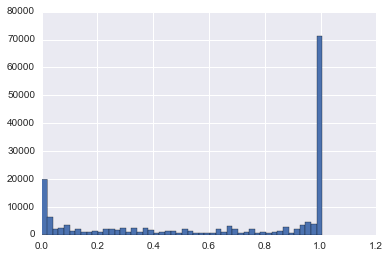

In [368]:
result.per.hist(bins=50)

Note: `areakm2_x` is the actual overlap between pairs of PA and species, while `areakm2_y` refers to the size of WH site.

In [9]:
result.head(5)

,Unnamed: 0,wdpaid,id_no,areakm2_x,areakm2_y,per,en_name,fr_name,status_yr,rep_area,...,phylum_name,class_name,order_name,family_name,genus_name,species_name,category,biome_marine,biome_freshwater,biome_terrestrial
0,0,191,2057.0,106497.703640,146962.025607,0.724661,Galápagos Islands,Îles Galápagos,1978,140665.14,...,CHORDATA,MAMMALIA,CARNIVORA,OTARIIDAE,Arctocephalus,galapagoensis,EN,t,f,t
1,1,191,2474.0,138918.354698,146962.025607,0.945267,Galápagos Islands,Îles Galápagos,1978,140665.14,...,CHORDATA,MAMMALIA,CETARTIODACTYLA,BALAENOPTERIDAE,Balaenoptera,acutorostrata,LC,t,f,f
2,2,2012,2474.0,2129.930772,5853.472599,0.363875,Everglades National Park,Parc national des Everglades\r\r\r\n,1979,5929.20,...,CHORDATA,MAMMALIA,CETARTIODACTYLA,BALAENOPTERIDAE,Balaenoptera,acutorostrata,LC,t,f,f
3,3,2018,2474.0,2549.486762,97284.250341,0.026207,Kluane / Wrangell-St Elias / Glacier Bay / Tat...,Kluane / Wrangell-St Elias / Glacier Bay / Tat...,1979,98391.21,...,CHORDATA,MAMMALIA,CETARTIODACTYLA,BALAENOPTERIDAE,Balaenoptera,acutorostrata,LC,t,f,f
4,4,2554,2474.0,4.105942,5502.386948,0.000746,Darien National Park,Parc national du Darien,1981,5970.00,...,CHORDATA,MAMMALIA,CETARTIODACTYLA,BALAENOPTERIDAE,Balaenoptera,acutorostrata,LC,t,f,f


In [10]:
result.dtypes

Unnamed: 0             int64
wdpaid                 int64
id_no                float64
areakm2_x            float64
areakm2_y            float64
per                  float64
en_name               object
fr_name               object
status_yr              int64
rep_area             float64
gis_area             float64
country               object
crit                  object
areakm2              float64
binomial              object
kingdom_name          object
phylum_name           object
class_name            object
order_name            object
family_name           object
genus_name            object
species_name          object
category              object
biome_marine          object
biome_freshwater      object
biome_terrestrial     object
dtype: object

# 2. Data preprocessing and exploration
The climate vulnerability analysis was done back using an older version of Red List 2009 ([methodology](http://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0065427)) and the current species range distribution data is the latest 2015-4 version. Therefore it is likely the taxanomies may change. In some cases, changes may be simple for example renaming genus name or other higher taxanomy, while others may be extremely convoluted, involving spliting of one previously recognised species into multiple ones or vice versa merging previously different species. It is very difficult to reconcile such differences.

Here, I explore such mismatches between birds, amphibians and warm water reef-building corals.


In [11]:
print('Total birds in SIS,', (sis['class'] == 'AVES').sum())
# birds SIS
sis_bird = sis[sis['class']=='AVES']

Total birds in SIS, 10424


In [12]:
print('unique birds in CCV analysis:', bird.Fullname.unique().size)
print('unique birds in SIS:', sis_bird.friendly_name.unique().size)

unique birds in CCV analysis: 9856
unique birds in SIS: 10424


Differences between bird numbers, and similarly other taxa groups

In [13]:
sis_amp = sis[sis['class']=='AMPHIBIA']

print('Birds in CCV but not in SIS:', np.setdiff1d(bird.Fullname.unique(), sis_bird.friendly_name.unique()).size)
print('Total birds in CCV:', bird.index.size)
print('Amphibians in CCV but not in SIS:', np.setdiff1d(amp.Fullname.unique(), sis_amp.friendly_name.unique()).size)
print('Total amphibians in CCV:', amp.index.size)
print('Corals in CCV but not in SIS:', np.setdiff1d(coral_unique.Fullname.unique(), sis.friendly_name.unique()).size)
print('Total corals in CCV:', coral_unique.index.size)

Birds in CCV but not in SIS: 673
Total birds in CCV: 9856
Amphibians in CCV but not in SIS: 502
Total amphibians in CCV: 6204
Corals in CCV but not in SIS: 19
Total corals in CCV: 797


**Given the relatively low number and proportion of such missing species due to taxonomic changes, it is unlikely the result may change significantly. For the purpose of deriving a globally consistent picture, we simply exclude these species.**

Note the datatype in the result table is somehow different (int vs float) and it will impact comparisons. This needs to be explicited addressed, by rounding.

In [14]:
result.ix[176646].id_no

61623293.999999993

`result.id_no.astype('int64')` will not work as it simply gets rid of its fraction. Instead `round(0)` method should be used

In [15]:
result['id_no_int'] = result.id_no.round(0)

The effect can be easily illustrated. The difference has reduced from 1581 to 36.

In [16]:
(result.id_no.isin(sis.taxonid)).sum()

164315

In [17]:
dif_spatial = np.setdiff1d(result.id_no, sis.taxonid)
dif_spatial.size

1581

In [18]:
dif_spatial = np.setdiff1d(result.id_no_int, sis.taxonid)
dif_spatial.size

36

Let's take a look at the differece, i.e., IDS in the intersection result but not in the SIS.

In [19]:
dif_sis = result[result.id_no.isin(dif_spatial)][['id_no', 'class_name', 'binomial']]

In [20]:
dif_sis['class_name'].unique()

array(['ACTINOPTERYGII', 'MAGNOLIOPSIDA', 'LILIOPSIDA', 'GASTROPODA',
       'MAMMALIA', 'SARCOPTERYGII', 'INSECTA', 'BIVALVIA'], dtype=object)

Now it is clear that the odd missing species should not impact our analysis, which only looks at birds, amphibians and corals. In other words, the IDs in the result table having corresponding SIS entries. Given that the result table contains already all SIS information, there is no need to join the SIS table. What needs to be address now is to compare the result table directly with the climate vulnerability analysis.

In [21]:
dif_amp_result = np.setdiff1d(amp.Fullname, result.binomial)
dif_amp_sis = np.setdiff1d(amp.Fullname, sis.friendly_name)
dif_amp_result.size, dif_amp_sis.size

(4174, 502)

In [22]:
# get amp_result using CCV, SIS and partialoverlap_result
amp_result = pd.merge(amp, sis_amp, left_on = 'Fullname', right_on='friendly_name')
amp_result = pd.merge(amp_result, result, left_on='taxonid', right_on='id_no_int')

In [23]:
amp_result.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755],
           dtype='int64', length=4756)

In [24]:
amp.index

RangeIndex(start=0, stop=6204, step=1)

In [25]:
# what happens if a join is made directly without going through SIS and ID_NO
test_amp = pd.merge(amp, result, left_on='Fullname', right_on='binomial')

In [26]:
test_amp.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771],
           dtype='int64', length=4772)

In [27]:
# the difference
test_dif = np.setdiff1d(test_amp.id_no_int.unique(), amp_result.id_no_int.unique())
test_dif.size

11

There might be something peculiar happening - as in theory the number should match. The fact there are 11 mismatching names suggest there is a possibility that the name in SIS still mismatches. See below the missing species using the CCV-SIS join.

In [28]:
test_amp[test_amp.id_no_int.isin(test_dif)]

,SVP_ID,SIS_GAA_ID,GAA Family,Genus,Species,Fullname,Threatened,SUSC_A_Habitats,SUSC_A_aquatic larvae,SUSC_B_Temperature Range,...,class_name,order_name,family_name,genus_name,species_name,category,biome_marine,biome_freshwater,biome_terrestrial,id_no_int
398,3260,9380,MICROHYLIDAE,Anodonthyla,boulengerii,Anodonthyla boulengerii,NaN,L,L,L,...,AMPHIBIA,ANURA,MICROHYLIDAE,Anodonthyla,boulengeri,LC,f,f,t,57674.0
797,2771,32142,MICROHYLIDAE,Chiasmocleis,panamensis,Chiasmocleis panamensis,NaN,L,H,H,...,AMPHIBIA,ANURA,MICROHYLIDAE,Elachistocleis,panamensis,LC,f,t,t,57761.0
798,2771,32142,MICROHYLIDAE,Chiasmocleis,panamensis,Chiasmocleis panamensis,NaN,L,H,H,...,AMPHIBIA,ANURA,MICROHYLIDAE,Elachistocleis,panamensis,LC,f,t,t,57761.0
978,4258,51160,SALAMANDRIDAE,Cynops,cyanurus,Cynops cyanurus,NaN,L,L,L,...,AMPHIBIA,CAUDATA,SALAMANDRIDAE,Hypselotriton,cyanurus,LC,f,t,t,59440.0
979,4258,51160,SALAMANDRIDAE,Cynops,cyanurus,Cynops cyanurus,NaN,L,L,L,...,AMPHIBIA,CAUDATA,SALAMANDRIDAE,Hypselotriton,cyanurus,LC,f,t,t,59440.0
980,3529,51161,SALAMANDRIDAE,Cynops,orientalis,Cynops orientalis,NaN,L,L,L,...,AMPHIBIA,CAUDATA,SALAMANDRIDAE,Hypselotriton,orientalis,LC,f,t,t,59442.0
981,3529,51161,SALAMANDRIDAE,Cynops,orientalis,Cynops orientalis,NaN,L,L,L,...,AMPHIBIA,CAUDATA,SALAMANDRIDAE,Hypselotriton,orientalis,LC,f,t,t,59442.0
982,3529,51161,SALAMANDRIDAE,Cynops,orientalis,Cynops orientalis,NaN,L,L,L,...,AMPHIBIA,CAUDATA,SALAMANDRIDAE,Hypselotriton,orientalis,LC,f,t,t,59442.0
983,3529,51161,SALAMANDRIDAE,Cynops,orientalis,Cynops orientalis,NaN,L,L,L,...,AMPHIBIA,CAUDATA,SALAMANDRIDAE,Hypselotriton,orientalis,LC,f,t,t,59442.0
1306,2789,20162,MICROHYLIDAE,Gastrophryne,pictiventris,Gastrophryne pictiventris,NaN,L,L,H,...,AMPHIBIA,ANURA,MICROHYLIDAE,Hypopachus,pictiventris,LC,f,t,t,57816.0


As a result, use direct join between RL intersection and CCV.

In [29]:
## remove test variables 
del amp_result, test_amp

# 3. Analysis
There are several tasks outstanding:
1. first of all, a reasonable and defendable cut-off percentage overlap value needs to be calculated as to determine what constitutes species found within World Heritage sites.
2. once the value is decided, the `wdpaid, id_no` look up table is then filtered, and it can be further refined by variables such as IUCN Red List category, CCV traits etc.
3. because the first question needs answering before further steps, and it may change. It is advisable to create a function to facilitate such process. i.e. a function such as:
```python
def f(input_result_table, cut-off-value):
    new_table= input_result_table[input_result_table.per >= cut-off-value]
    # function to produces outputs based on the result table
    result = process_result(new_table)
    return result
```

## 3.1 The cut-off value
The EOO (extent of occurence) nature of the Red List species distribution polygon, an overlap between a species and a WH site does not necessarily suggest that a species is present. This is made worse if only part of the distribution polygon intersects with the WH site - this could be a digitisation error or simply inaccuracy due to a scale mismatch. Such 'species within WH sites' as a result must be removed. Quantiles of can be a useful way to look at.

In [30]:
# what happens if a join is made directly without going through SIS and ID_NO
result_amp = pd.merge(amp, result, left_on='Fullname', right_on='binomial')
result_bird = pd.merge(bird, result, left_on='Fullname', right_on='binomial')
result_coral = pd.merge(coral_unique, result, left_on='Fullname', right_on='binomial')

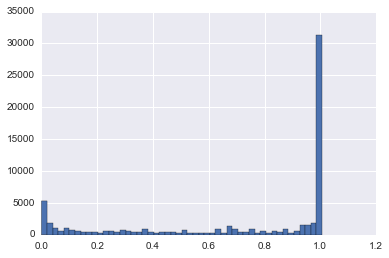

In [31]:
all_per_abc = pd.concat([result_amp.per, result_bird.per, result_coral.per])
all_per_abc.hist(bins=50)

The large majority of overlaps are fairely big, suggesting sites WH are generally entirely covered by species. This is not surprising as most species distributions polygons are a few magnitudes bigger than WH sites. Yet, it is possible that range-restricted and/or threatened species may have much smaller range.

In [32]:
all_per_abc.quantile(0.5)

0.9582745841568836

For illustration purposes, note the difference of choosing a cut-off value between 10% and 15% is not signicant (~2%, or ~2000 pa-species pair less). This should have minimal effects on the result.

In [33]:
(all_per_abc>0.15).sum(), (all_per_abc>0.1).sum(), (all_per_abc>0.05).sum()

(56508, 58029, 60301)

In [34]:
((all_per_abc>0.1).sum() - (all_per_abc>0.15).sum())/all_per_abc.index.size

0.022358440642088553

However, if we look at amphibians, birds and mammals separately, it is easily noticeable that corals have significant number of low percentage overlaps. This is because marine World Heritage sites tend to be rather extensive and huge compared to coral distributions which are coastal. Thus it is important to examine the absolute overlap as well for corals.

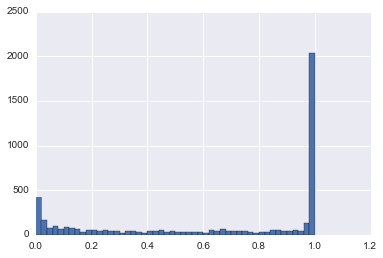

In [35]:
result_amp.per.hist(bins=50)

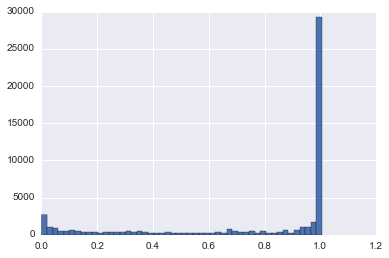

In [36]:
result_bird.per.hist(bins=50)

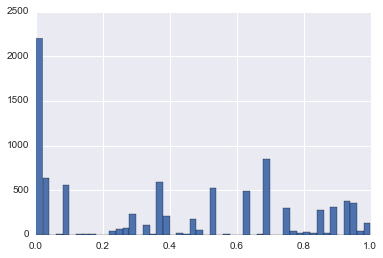

In [37]:
result_coral.per.hist(bins=50)

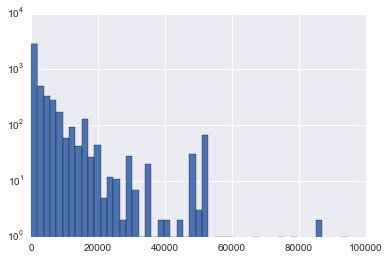

In [38]:
result_amp.areakm2_x.hist(bins =50, log=True)

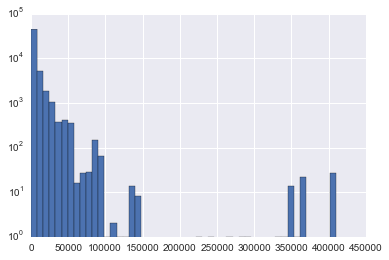

In [39]:
result_bird.areakm2_x.hist(bins =50, log=True)

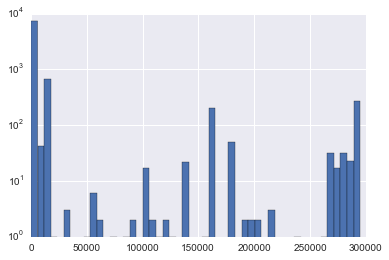

In [40]:
result_coral.areakm2_x.hist(bins =50, log=True)

The histograms show all three taxa have a bimodal distribution, with significant number of values near two poles (very large overlaps or very small ones)

In [41]:
result_coral.sort_values('per', ascending=True)[['en_name', 'binomial', 'areakm2_x', 'per']].head(20)

,en_name,binomial,areakm2_x,per
5363,Darien National Park,Millepora intricata,0.033701,0.000006
7471,Tropical Rainforest Heritage of Sumatra,Podabacia motuporensis,0.874951,0.000034
2550,Tropical Rainforest Heritage of Sumatra,Ctenactis albitentaculata,0.999503,0.000038
169,Tropical Rainforest Heritage of Sumatra,Acropora abrolhosensis,0.999503,0.000038
4692,Henderson Island,Leptastrea pruinosa,0.002691,0.000065
430,Henderson Island,Acropora cytherea,0.002691,0.000065
777,Henderson Island,Acropora hyacinthus,0.002691,0.000065
1577,Henderson Island,Acropora subulata,0.002691,0.000065
3214,Henderson Island,Favia matthaii,0.002691,0.000065
755,Henderson Island,Acropora humilis,0.002691,0.000065


In [42]:
result_coral[['en_name', 'binomial', 'areakm2_x', 'per']][result_coral.en_name.isin(['Henderson Island'])].head()

,en_name,binomial,areakm2_x,per
195,Henderson Island,Acropora aculeus,0.002691,0.000065
281,Henderson Island,Acropora austera,0.002691,0.000065
350,Henderson Island,Acropora cerealis,0.002691,0.000065
430,Henderson Island,Acropora cytherea,0.002691,0.000065
480,Henderson Island,Acropora digitifera,0.002691,0.000065


The threshold value can be reasonably justified by using both the perentage overlap and actual overlap. It is obvious if the entire WH site is covered by a species, then it should be counted. If the percentage overlap is too small, it could be either due to an inaccurate boundary, in which case, the species should not be counted; or a genunie overlap if the WH is considerably larger. Therefore, by adding an additional test to the absolute overlap value in $km^2$, ommissions due to small percentage overlap can be reduced. 

Let's test the effect of using various emperical values of `per` and `abskm2` to remove artifical overlaps caused by the inaccuracy of boundaries. This represents an optimistic estimate of the number of species in WH (reinforced by the nature of Red List EOO)

In [43]:
def test_params(per=None, abkm2=None):
    if per is None and abkm2 is None:
        result = None
    if per and abkm2: # both conditions are applied
        result = [(result_taxa[(result_taxa.per>per)|(result_taxa.areakm2_x>abkm2)].index.size, result_taxa.index.size) for \
 result_taxa in [result_amp, result_bird, result_coral]]
    elif per and abkm2 is None: # only per
        result = [(result_taxa[(result_taxa.per>per)].index.size, result_taxa.index.size) for \
 result_taxa in [result_amp, result_bird, result_coral]]
    elif per is None and abkm2:
        result = [(result_taxa[(result_taxa.areakm2_x>abkm2)].index.size, result_taxa.index.size) for \
 result_taxa in [result_amp, result_bird, result_coral]]
    else:
        return None
        
    print(per, abkm2, result)

# # check the number of rows after applying criteria
# for each in zip(['after', 'before'], *test_params(0.15, 1)):
#     print(each)

# per, abkm2, (after and before) for amp, bird and coral
print('---only per---')
test_params(0.05)
test_params(0.15)
test_params(0.25)
test_params(0.50)
print('---only abs km2---')
test_params(abkm2=1)
test_params(abkm2=5)
test_params(abkm2=10)
print('--- per or abs km2---')
test_params(0.15, 1)
test_params(0.15, 2)
test_params(0.25, 1)
test_params(0.25, 2)
test_params(0.25, 5)

---only per---
0.05 None [(4140, 4772), (50190, 54446), (5971, 8810)]
0.15 None [(3751, 4772), (47361, 54446), (5396, 8810)]
0.25 None [(3504, 4772), (45570, 54446), (5293, 8810)]
0.5 None [(3047, 4772), (41125, 54446), (3795, 8810)]
---only abs km2---
None 1 [(4689, 4772), (53712, 54446), (8445, 8810)]
None 5 [(4575, 4772), (52187, 54446), (7628, 8810)]
None 10 [(4523, 4772), (51560, 54446), (7326, 8810)]
--- per or abs km2---
0.15 1 [(4731, 4772), (54144, 54446), (8445, 8810)]
0.15 2 [(4711, 4772), (53852, 54446), (7694, 8810)]
0.25 1 [(4731, 4772), (54139, 54446), (8445, 8810)]
0.25 2 [(4701, 4772), (53704, 54446), (7694, 8810)]
0.25 5 [(4661, 4772), (53298, 54446), (7628, 8810)]


The result corroborates the distributions that percentage overlaps are *sensitive* and their change has a considerable impact on the number of filtered rows, while s small increase in absolute area in $km^2$ seems to have little effect. It is observed that an increase of per from `15%` to `25%` poses little change. 

**The threshold values chosen here may present a rather insigificant factor compared to the assumption made by the EOO intersection, i.e., even though a species overlaps 100% with a given WH, it may still be absent. However this approach remains a popular method in estimating global species conservation and offer a consistent view for comprehensively assessed species, in the absence of true area of occupancy (AOO) data.**

I use `15%` and `1km^2` as cut-off values

## 3.2 Climate vulnerability species inside WH sites
To be policy relavant at a site level, it's imperative that climate vulnerability information on individual World Heritage sites be obtained. 
This analysis illustrates how many amphibians, birds and coral species are affected by climate change in each World Heritage site, by using both the total number of climate vulnerable species and their proportion. Further aggretations can be used to reveal each component within sensitivity, low adaptability and exposure.

In [44]:
# get filtered result
result_amp_f, result_bird_f, result_coral_f = [result_taxa[(result_taxa.per>.15)|(result_taxa.areakm2_x>1)] for \
 result_taxa in [result_amp, result_bird, result_coral]]

# get species numbers
print('Filtered', 'Total-intersect', 'Total')
print(result_amp_f.Fullname.unique().size, result_amp.Fullname.unique().size, amp.Fullname.unique().size)
print(result_bird_f.Fullname.unique().size, result_bird.Fullname.unique().size, bird.Fullname.unique().size)
print(result_coral_f.Fullname.unique().size, result_coral.Fullname.unique().size, coral.Fullname.unique().size)

Filtered Total-intersect Total
2013 2030 6204
6914 6924 9856
724 727 797


Using a lambda function as an argument to get 
1. total number of high vulnerability species per WH site 
2. total number of species per WH site 
3. percentage of the high vulnerability species per WH site

In [45]:
## agg_dict passed to do multiple aggregation at the same time
## x is a group of FINAL_SCOREs
agg_dict = {'FINAL_SCORE':\
            {'H_vul_per': lambda x: (x=='H').sum()/x.size, \
             'total_H_vul': lambda x: (x=='H').sum(),\
             'total_vul':len}}

## amp
amp_v = result_amp_f.groupby(['wdpaid', 'en_name']).agg(agg_dict).reset_index()
amp_v.columns = amp_v.columns.droplevel()

# birds
bird_v = result_bird_f.groupby(['wdpaid', 'en_name']).agg(agg_dict).reset_index()
bird_v.columns = bird_v.columns.droplevel()

# corals
coral_v = result_coral_f.groupby(['wdpaid', 'en_name']).agg(agg_dict).reset_index()
coral_v.columns = coral_v.columns.droplevel()

In [46]:
bird_v.head()

,,,H_vul_per,total_H_vul,total_vul
0,191,Galápagos Islands,0.129412,11,85
1,197,Tikal National Park,0.179661,53,295
2,2004,Dinosaur Provincial Park,0.126866,17,134
3,2005,Nahanni National Park,0.141667,17,120
4,2006,Simien National Park,0.096886,28,289


It is necessary to add the missing labels for the two columns

In [47]:
# rename column names. One cannot do: amp_v.columns[1] = newcolumn_name
new_columns = amp_v.columns.values
new_columns[:2] = ['wdpaid', 'en_name']

amp_v.columns = new_columns
bird_v.columns = new_columns
coral_v.columns = new_columns

Graphs to show both the percentage (the number of species with FINAL SCORE =='H' against all species), and the total number of species that are highly vulnerable. 

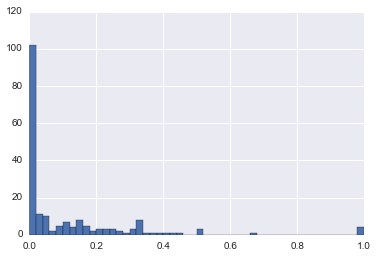

In [48]:
# percentage of H distribution
amp_v.H_vul_per.hist(bins=50)

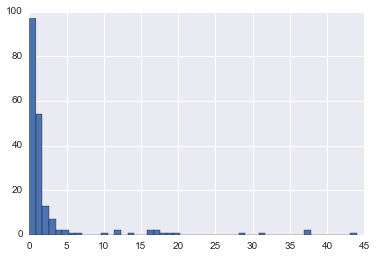

In [49]:
# total number of H distribution
amp_v.total_H_vul.hist(bins=50)

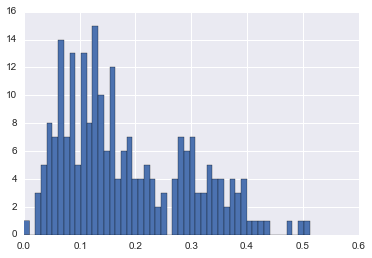

In [50]:
# percentage of H distribution
bird_v.H_vul_per.hist(bins=50)

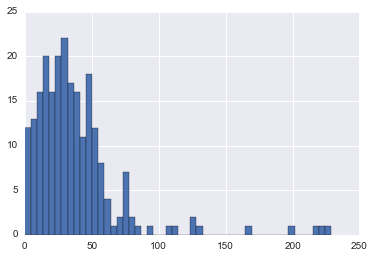

In [51]:
# total number of H distribution
bird_v.total_H_vul.hist(bins=50)

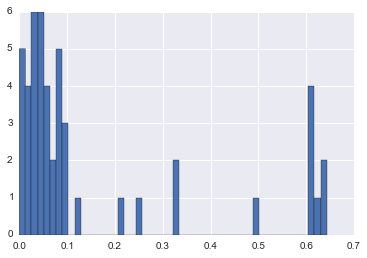

In [52]:
# percentage of H distribution
coral_v.H_vul_per.hist(bins=50)

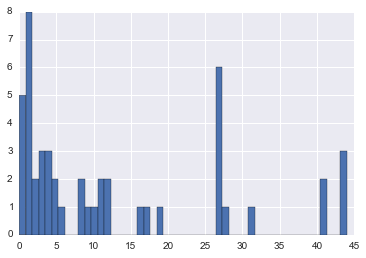

In [53]:
# total number of H distribution
coral_v.total_H_vul.hist(bins=50)

In [54]:
print('Top WHs with high number of CV birds\n', bird_v.sort_values('total_H_vul', ascending=False).head(10))
print('==================')
print('Top WHs with high percentage of CV birds\n', bird_v.sort_values('H_vul_per', ascending=False).head(10))

Top WHs with high number of CV birds
      wdpaid                                            en_name  H_vul_per  \
92    61612                              Canaima National Park   0.366987   
72    17760                                 Manú National Park   0.266350   
149  220296                Central Amazon Conservation Complex   0.370307   
151  220298                    Central Suriname Nature Reserve   0.411157   
41     9614                               Sangay National Park   0.268730   
148  220295                  Noel Kempff Mercado National Park   0.227979   
52    10903  Talamanca Range-La Amistad Reserves / La Amist...   0.225750   
15     2554                               Darien National Park   0.240310   
90    61610                           Los Katíos National Park   0.241228   
82    26651                           Río Abiseo National Park   0.211240   

     total_H_vul  total_vul  
92           229        624  
72           224        841  
149          217        

In [55]:
print('Top WHs with high number of CV amphibians\n', amp_v.sort_values('total_H_vul', ascending=False).head(10))
print('==================')
print('Top WHs with high percentage of CV amphibian\n', amp_v.sort_values('H_vul_per', ascending=False).head(10))

Top WHs with high number of CV amphibians
      wdpaid                                            en_name  H_vul_per  \
49    10903  Talamanca Range-La Amistad Reserves / La Amist...   0.325926   
133  220298                    Central Suriname Nature Reserve   0.445783   
67    17760                                 Manú National Park   0.342593   
83    61612                              Canaima National Park   0.360465   
131  220296                Central Amazon Conservation Complex   0.318681   
152  902347                 Cape Floral Region Protected Areas   0.425532   
162  903062                      Rainforests of the Atsinanana   0.120253   
127  220292                                      Kinabalu Park   0.260870   
128  220293                          Gunung Mulu National Park   0.293103   
120  198296                    Area de Conservación Guanacaste   0.326923   

     total_H_vul  total_vul  
49            44        135  
133           37         83  
67            37   

In [56]:
amp_v.quantile(0.9)

wdpaid         5.555120e+08
H_vul_per      3.320513e-01
total_H_vul    4.800000e+00
total_vul      5.800000e+01
dtype: float64

In [57]:
amp_v.quantile(0.1)

wdpaid         2574.2
H_vul_per         0.0
total_H_vul       0.0
total_vul         3.0
dtype: float64

In [58]:
bird_v.quantile(0.9)

wdpaid         5.555120e+08
H_vul_per      3.503704e-01
total_H_vul    6.720000e+01
total_vul      4.516000e+02
dtype: float64

In [59]:
bird_v.quantile(0.1)

wdpaid         2577.800000
H_vul_per         0.058983
total_H_vul       9.000000
total_vul        56.600000
dtype: float64

For communications purposes, it may be convenient to have a single indicator/index to indicate whether a given WH site is considered *climate vulnerable* for some taxon (in this case amphibians). The questions then becomes how such a cut-off value can be reasonable calculated and can be meaningfully applied. One way is to, again, use quantile cut-off values for total number of highly vulnerable species and percentage overlap. However, any ranking created using quantile  only compares within WH sites. Ideally, this should be derived using a global metric. Perhaps this is an important caveat. One needs to know about other taxa before making a decision as they should be consistent. 

Questions:
- make sense to rank? 10% sounds a good cut-off value?

Top10, top 50, top200

WH sites with high proportion seem to have a low total number of CV amphibians. Thus using proportion alone may not paint a full picture. It is conceivable that a combination of both number and propertion is needed to classify/rank WH sites.

## 3.4 Climate vulnerability species inside WH sites, new methods

While the above methods work well, similar stats for other columns need considerable manual coding. In this study, depending on the taxon of interest, there may be as high as 20 replications (a total of ~60 if all three taxa are conisidered). Therefore it is necessary to find a way through which such aggregations could be calculated simply and more scalable.

In [60]:
# get all fields and pick those we need for the stats
print(result_amp_f.columns)
print(result_bird_f.columns)
print(result_coral_f.columns)

Index(['SVP_ID', 'SIS_GAA_ID', 'GAA Family', 'Genus', 'Species', 'Fullname',
       'Threatened', 'SUSC_A_Habitats', 'SUSC_A_aquatic larvae',
       'SUSC_B_Temperature Range', 'SUSC_B_Precipitation Range',
       'SUSC_C_explosive breeder', 'SUSC_D_disease', 'SENSITIVITY',
       'ADAPT_A_barriers', 'ADAPT_A_dispersal_distance',
       'ADAPT_C_Slow_Gen_Turnpover', 'LOW_ADAPTABILITY', 'EXP_Sea Level',
       'EXP_MeanTemperature', 'EXP_MeanRainfall', 'EXP_AADTemperature',
       'EXP_AADRainfall', 'EXPOSURE', 'FINAL_SCORE', 'Final_Pessimistic',
       'Score_HorS', 'SensXLAdaptability', 'SensXExposure', 'LAdaptXExposure',
       'Threatened_and_Vulnerable', 'Unnamed: 0', 'wdpaid', 'id_no',
       'areakm2_x', 'areakm2_y', 'per', 'en_name', 'fr_name', 'status_yr',
       'rep_area', 'gis_area', 'country', 'crit', 'areakm2', 'binomial',
       'kingdom_name', 'phylum_name', 'class_name', 'order_name',
       'family_name', 'genus_name', 'species_name', 'category', 'biome_marine',
      

In [61]:
# Selected columns, based on the df.columns for each taxon
## amphibian
a_columns = ['SUSC_A_Habitats', 'SUSC_A_aquatic larvae',
 'SUSC_B_Temperature Range', 'SUSC_B_Precipitation Range',
 'SUSC_C_explosive breeder', 'SUSC_D_disease', 'SENSITIVITY',
 'ADAPT_A_barriers', 'ADAPT_A_dispersal_distance',
 'ADAPT_C_Slow_Gen_Turnpover', 'LOW_ADAPTABILITY', 
 'EXP_Sea Level',
 'EXP_MeanTemperature', 'EXP_MeanRainfall', 'EXP_AADTemperature',
'EXP_AADRainfall', 'EXPOSURE', 'FINAL_SCORE']

## birds
b_columns = ['FINAL_SCORE', '__hab_specialisation', 
'__microhabitat', '__ForestDependence', '__TemperatureRange',
'__PrecipRange', '__Species dependence', '__PopnSize',
'__EffectivePopnSize', 'SENSITIVITY', '__Dispersal distance limited',
'__Dispersal barriers', '__Low genetic diversity', '__clutch size',
'__Gen_Length', 'LOW_ADAPTABILITY', '__EXP_Sea Inundation',
'__EXP_MeanTemperature', '__EXP_AADTemperature', '__EXP_MeanPrecip',
'__EXP_AADPrecip', 'EXPOSURE']

## corals
c_columns = ['FINAL_SCORE', '_Few habitats', '_narrow depth rng',
       '_Larval vulnerabilityH', '_ShallowH', '_PastMortalityH', '_zooxH',
       '_Rare', 'SENSITIVITY', '_Short dispersal distance',
       '_dispersal barriers', '_ColonyMaxAge', '_SlowGrowthRate',
       'LOW_ADAPTABILITY', '_ProportionArag<3', '_MeanDHM', 'EXPOSURE']


In [62]:
# apply summation of HLU to each column, count how many occurences of each H, L, U and percentage
def get_hlu(x):
    return pd.Series({'H': (x=='H').sum(), 'L': (x=='L').sum(), 'U': (x=='U').sum(), 'per_H': (x=='H').sum()/x.size})

# apply get_hlu to each df
def apply_func(df, select_columns):
    # for each column of the df apply a function
    return df[select_columns].apply(get_hlu).T

# ======= GENERIC VERSION ======
# get unique value of the series and count how many occurences of each unique value
def generic_count(x):
    # x is a pd.Series object
    unique_values = x.unique()
    return pd.Series({value: (x==value).sum() for value in unique_values})

def apply_func_mk2(df):
    return df[summary_columnsy_columns].apply(generic_count).T

# ======= about 'apply' =======
## dfgroupby.apply: takes a df as argument(for each sub df defined by groupby criteria)
## dataframe.apply: takes a series as argument (for each of the columns in the df)
## series.apply: takes a value as argument (for each value of the series)


In [63]:
## split into df for each unique wdpaid-en_name combinations
## for each df apply the logic
amp_vv =  result_amp_f.groupby(['wdpaid', 'en_name']).apply(apply_func, a_columns).reset_index()
bird_vv = result_bird_f.groupby(['wdpaid', 'en_name']).apply(apply_func, b_columns).reset_index()
coral_vv = result_coral_f.groupby(['wdpaid', 'en_name']).apply(apply_func, c_columns).reset_index()

# amp_vvv = groups.apply(apply_func_mk2).reset_index()

In [64]:
## spot checks
bird_vv[bird_vv.wdpaid == 191]

,wdpaid,en_name,level_2,H,L,U,per_H
0,191,Galápagos Islands,FINAL_SCORE,11.0,74.0,0.0,0.129412
1,191,Galápagos Islands,__hab_specialisation,4.0,81.0,0.0,0.047059
2,191,Galápagos Islands,__microhabitat,1.0,84.0,0.0,0.011765
3,191,Galápagos Islands,__ForestDependence,8.0,77.0,0.0,0.094118
4,191,Galápagos Islands,__TemperatureRange,2.0,69.0,14.0,0.023529
5,191,Galápagos Islands,__PrecipRange,20.0,51.0,14.0,0.235294
6,191,Galápagos Islands,__Species dependence,0.0,85.0,0.0,0.000000
7,191,Galápagos Islands,__PopnSize,12.0,56.0,17.0,0.141176
8,191,Galápagos Islands,__EffectivePopnSize,15.0,53.0,17.0,0.176471
9,191,Galápagos Islands,SENSITIVITY,32.0,39.0,14.0,0.376471


In [65]:
bird_vv[bird_vv.wdpaid == 2008]

,wdpaid,en_name,level_2,H,L,U,per_H
132,2008,Bia?owie?a Forest,FINAL_SCORE,60.0,119.0,0.0,0.335196
133,2008,Bia?owie?a Forest,__hab_specialisation,0.0,179.0,0.0,0.000000
134,2008,Bia?owie?a Forest,__microhabitat,12.0,167.0,0.0,0.067039
135,2008,Bia?owie?a Forest,__ForestDependence,13.0,166.0,0.0,0.072626
136,2008,Bia?owie?a Forest,__TemperatureRange,0.0,176.0,3.0,0.000000
137,2008,Bia?owie?a Forest,__PrecipRange,152.0,24.0,3.0,0.849162
138,2008,Bia?owie?a Forest,__Species dependence,0.0,179.0,0.0,0.000000
139,2008,Bia?owie?a Forest,__PopnSize,0.0,179.0,0.0,0.000000
140,2008,Bia?owie?a Forest,__EffectivePopnSize,0.0,179.0,0.0,0.000000
141,2008,Bia?owie?a Forest,SENSITIVITY,161.0,18.0,0.0,0.899441


In [66]:
result_amp_f[result_amp_f.wdpaid == 191]

,SVP_ID,SIS_GAA_ID,GAA Family,Genus,Species,Fullname,Threatened,SUSC_A_Habitats,SUSC_A_aquatic larvae,SUSC_B_Temperature Range,...,class_name,order_name,family_name,genus_name,species_name,category,biome_marine,biome_freshwater,biome_terrestrial,id_no_int


In [67]:
amp_vv[amp_vv.wdpaid == 191]
coral_vv[coral_vv.wdpaid == 191]

,wdpaid,en_name,level_2,H,L,U,per_H
0,191,Galápagos Islands,FINAL_SCORE,2.0,19.0,0.0,0.095238
1,191,Galápagos Islands,_Few habitats,4.0,17.0,0.0,0.190476
2,191,Galápagos Islands,_narrow depth rng,4.0,16.0,1.0,0.190476
3,191,Galápagos Islands,_Larval vulnerabilityH,2.0,19.0,0.0,0.095238
4,191,Galápagos Islands,_ShallowH,4.0,16.0,1.0,0.190476
5,191,Galápagos Islands,_PastMortalityH,11.0,10.0,0.0,0.523810
6,191,Galápagos Islands,_zooxH,15.0,6.0,0.0,0.714286
7,191,Galápagos Islands,_Rare,3.0,18.0,0.0,0.142857
8,191,Galápagos Islands,SENSITIVITY,21.0,0.0,0.0,1.000000
9,191,Galápagos Islands,_Short dispersal distance,0.0,18.0,3.0,0.000000


Having more CCV species, having more CCV species in proportion indicates WH sites, whose species are more susceptible to adverse impact due to climate change. 

Questions and statements that can be made?
- within WH sites, the top sites re CCV species number and proportion, by taxa. Narrative: more consideration to mitigate adverse effect of CCV to species

## 3.5 Climate vulnerability inside the entire WH network
This section looks at individual taxon within the entire network. A comparison is then made to examine whether or not the WH network house species that are more vulnerable to climate change. Because the result contains many duplicate species rows (due to different sites having the same species), the first step is to get a unique list of species within all WH sites.


In [157]:
# combine species in WH result and all results, by taxa
## get a unique set of species within each taxon
amp_selected = result_amp_f.groupby('id_no_int').first().reset_index()
bird_selected = result_bird_f.groupby('id_no_int').first().reset_index()
coral_selected = result_coral_f.groupby('id_no_int').first().reset_index()

## function to aggregate result and apply hlu function to all columns
def get_agg_result(unique_taxon_result, taxon_columns):
    return unique_taxon_result[taxon_columns].apply(get_hlu).T


amp_total = pd.merge(get_agg_result(amp_selected, a_columns), \
                    get_agg_result(amp, a_columns),
                    left_index = True, right_index=True, suffixes=('_wh', '_all'))

bird_total = pd.merge(get_agg_result(bird_selected, b_columns), \
                    get_agg_result(bird, b_columns),
                    left_index = True, right_index=True, suffixes=('_wh', '_all'))

coral_total = pd.merge(get_agg_result(coral_selected, c_columns), \
                    get_agg_result(coral, c_columns),
                    left_index = True, right_index=True, suffixes=('_wh', '_all'))

In [374]:
amp_total

,H_wh,L_wh,U_wh,per_H_wh,H_all,L_all,U_all,per_H_all
SUSC_A_Habitats,220.0,1783.0,10.0,0.109290,1509.0,4539.0,156.0,0.243230
SUSC_A_aquatic larvae,330.0,1673.0,10.0,0.163934,955.0,5085.0,164.0,0.153933
SUSC_B_Temperature Range,386.0,1626.0,1.0,0.191754,1519.0,4557.0,128.0,0.244842
SUSC_B_Precipitation Range,479.0,1533.0,1.0,0.237953,1519.0,4557.0,128.0,0.244842
SUSC_C_explosive breeder,162.0,1629.0,222.0,0.080477,316.0,4113.0,1775.0,0.050935
SUSC_D_disease,436.0,1577.0,0.0,0.216592,1307.0,4897.0,0.0,0.210671
SENSITIVITY,1340.0,606.0,67.0,0.665673,4453.0,1365.0,386.0,0.717763
ADAPT_A_barriers,183.0,1661.0,169.0,0.090909,745.0,3900.0,1559.0,0.120084
ADAPT_A_dispersal_distance,501.0,1493.0,19.0,0.248882,1569.0,4522.0,113.0,0.252901
ADAPT_C_Slow_Gen_Turnpover,609.0,586.0,818.0,0.302534,2073.0,899.0,3232.0,0.334139


In [394]:
a = amp_total[['H_wh', 'L_wh', 'U_wh']].sum(1)/amp_total[['H_all', 'L_all', 'U_all']].sum(1)
pd.concat([amp_total.H_wh/amp_total.H_all, a], 1)
# (amp_total.H_wh + amp_total.L_wh + amp_total.U_wh)/(amp_total.H_all + amp_total.L_all + amp_total.U_all)

,0,1
SUSC_A_Habitats,0.145792,0.324468
SUSC_A_aquatic larvae,0.345550,0.324468
SUSC_B_Temperature Range,0.254115,0.324468
SUSC_B_Precipitation Range,0.315339,0.324468
SUSC_C_explosive breeder,0.512658,0.324468
SUSC_D_disease,0.333588,0.324468
SENSITIVITY,0.300921,0.324468
ADAPT_A_barriers,0.245638,0.324468
ADAPT_A_dispersal_distance,0.319312,0.324468
ADAPT_C_Slow_Gen_Turnpover,0.293777,0.324468


It appears that also fewer proportion of amphibians in WH sites are climate vulnerable

In [159]:
bird_total

,H_wh,L_wh,U_wh,per_H_wh,H_all,L_all,U_all,per_H_all
FINAL_SCORE,1336.0,5578.0,0.0,0.193231,2323.0,7533.0,0.0,0.235694
__hab_specialisation,849.0,6059.0,6.0,0.122794,1530.0,8306.0,20.0,0.155235
__microhabitat,703.0,6211.0,0.0,0.101678,1001.0,8855.0,0.0,0.101562
__ForestDependence,1527.0,5386.0,1.0,0.220856,2575.0,7277.0,4.0,0.261262
__TemperatureRange,1068.0,4401.0,1445.0,0.154469,1974.0,6118.0,1764.0,0.200284
__PrecipRange,1414.0,4055.0,1445.0,0.204513,2095.0,5997.0,1764.0,0.212561
__Species dependence,66.0,6848.0,0.0,0.009546,89.0,9767.0,0.0,0.009030
__PopnSize,393.0,1794.0,4727.0,0.056841,1084.0,2319.0,6453.0,0.109984
__EffectivePopnSize,558.0,1629.0,4727.0,0.080706,1410.0,1993.0,6453.0,0.143060
SENSITIVITY,4022.0,585.0,2307.0,0.581718,6290.0,719.0,2847.0,0.638190


In [160]:
coral_total

,H_wh,L_wh,U_wh,per_H_wh,H_all,L_all,U_all,per_H_all
FINAL_SCORE,111.0,582.0,31.0,0.153315,242.0,1198.0,154.0,0.151819
_Few habitats,160.0,564.0,0.0,0.220994,384.0,1210.0,0.0,0.240903
_narrow depth rng,169.0,529.0,26.0,0.233425,384.0,1140.0,70.0,0.240903
_Larval vulnerabilityH,133.0,589.0,2.0,0.183702,274.0,1316.0,4.0,0.171895
_ShallowH,172.0,527.0,25.0,0.237569,376.0,1156.0,62.0,0.235885
_PastMortalityH,312.0,412.0,0.0,0.430939,644.0,950.0,0.0,0.404015
_zooxH,669.0,54.0,1.0,0.924033,1478.0,114.0,2.0,0.927227
_Rare,144.0,575.0,5.0,0.198895,392.0,1190.0,12.0,0.245922
SENSITIVITY,723.0,1.0,0.0,0.998619,1592.0,2.0,0.0,0.998745
_Short dispersal distance,65.0,491.0,168.0,0.089779,144.0,1042.0,408.0,0.090339


Amphibians and birds in WH sites have consistently lower number of CCV species in proportion, compared to all ampbibians (14.9% to 22%) and birds (19.3% and 23.5%). Lower proportions are also observed in sensitivity, low adaptability and exposure.

Question: what does it mean? what statements can be realistically made?
1. is it because of WH sites, therefore these species are less vulnerable? Probably no, as these species are not restricted inside WH sites. Thus no statement can made about to justify the positive effect of WH sites.
2. WH contributes a good deal, as it covers % of H CCV species globally?
3. what others?

Corals show a consistent trend in proportion in terms of vulnerability, and SAE.

Test statistics for significance

per region (IUCN/UNESCO regions?) / biodiversity sites

In [235]:
amp_total

,H_wh,L_wh,U_wh,per_H_wh,H_all,L_all,U_all,per_H_all
SUSC_A_Habitats,220.0,1783.0,10.0,0.109290,1509.0,4539.0,156.0,0.243230
SUSC_A_aquatic larvae,330.0,1673.0,10.0,0.163934,955.0,5085.0,164.0,0.153933
SUSC_B_Temperature Range,386.0,1626.0,1.0,0.191754,1519.0,4557.0,128.0,0.244842
SUSC_B_Precipitation Range,479.0,1533.0,1.0,0.237953,1519.0,4557.0,128.0,0.244842
SUSC_C_explosive breeder,162.0,1629.0,222.0,0.080477,316.0,4113.0,1775.0,0.050935
SUSC_D_disease,436.0,1577.0,0.0,0.216592,1307.0,4897.0,0.0,0.210671
SENSITIVITY,1340.0,606.0,67.0,0.665673,4453.0,1365.0,386.0,0.717763
ADAPT_A_barriers,183.0,1661.0,169.0,0.090909,745.0,3900.0,1559.0,0.120084
ADAPT_A_dispersal_distance,501.0,1493.0,19.0,0.248882,1569.0,4522.0,113.0,0.252901
ADAPT_C_Slow_Gen_Turnpover,609.0,586.0,818.0,0.302534,2073.0,899.0,3232.0,0.334139


### Statistical testing on the finding
Is it possible that the statistical differences observed simply reflect the fact that WH network happens to draw a sample from the pool of all species and that the difference is only due to random sampling and nothing else. In other words, the difference is not because of WH capturing species of specific traits but random sampling. 

In [73]:
print('amp:', amp.index.size, 'in WH', amp_selected.index.size)
print('bird:', bird.index.size, 'in WH', bird_selected.index.size)
print('coral:', coral_unique.index.size, 'in WH', coral_selected.index.size)

amp: 6204 in WH 2013
bird: 9856 in WH 6914
coral: 797 in WH 724


In [74]:
amp_selected.head()

,id_no_int,SVP_ID,SIS_GAA_ID,GAA Family,Genus,Species,Fullname,Threatened,SUSC_A_Habitats,SUSC_A_aquatic larvae,...,phylum_name,class_name,order_name,family_name,genus_name,species_name,category,biome_marine,biome_freshwater,biome_terrestrial
0,520.0,4556,2661,LIMNODYNASTIDAE,Adelotus,brevis,Adelotus brevis,NaN,L,L,...,CHORDATA,AMPHIBIA,ANURA,LIMNODYNASTIDAE,Adelotus,brevis,NT,f,t,t
1,596.0,4760,100011,HYPEROLIIDAE,Afrixalus,aureus,Afrixalus aureus,NaN,L,H,...,CHORDATA,AMPHIBIA,ANURA,HYPEROLIIDAE,Afrixalus,aureus,LC,f,t,t
2,1272.0,3629,51121,CRYPTOBRANCHIDAE,Andrias,davidianus,Andrias davidianus,Y,L,L,...,CHORDATA,AMPHIBIA,CAUDATA,CRYPTOBRANCHIDAE,Andrias,davidianus,CR,f,t,f
3,1282.0,3644,13093,PLETHODONTIDAE,Aneides,aeneus,Aneides aeneus,NaN,H,L,...,CHORDATA,AMPHIBIA,CAUDATA,PLETHODONTIDAE,Aneides,aeneus,NT,f,f,t
4,2865.0,3109,15108,BOMBINATORIDAE,Bombina,bombina,Bombina bombina,NaN,L,L,...,CHORDATA,AMPHIBIA,ANURA,BOMBINATORIDAE,Bombina,bombina,LC,f,t,t


If I get repeated random samples from the pool, calculate the H_per value and then plot them...

In [75]:
# get a random sample of 2013 repeatedly and calculate H_per
# ===== explanation
# ## get a random sample without replacement
# a = amp[amp.SVP_ID.isin(np.random.choice(amp.SVP_ID, 2013, replace=False))]
# ## apply HLU and get the final score
# a[a_columns].apply(get_hlu).T.ix['FINAL_SCORE'].per_H

test_a = [amp[amp.SVP_ID.isin(np.random.choice(amp.SVP_ID, 2013, replace=False))][a_columns].apply(get_hlu).T.ix['FINAL_SCORE'].per_H\
          for i in range(1000)]

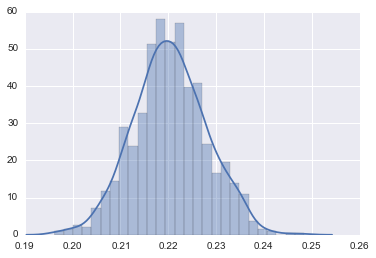

In [76]:
sns.distplot(test_a)

In [77]:
amp_total.ix['FINAL_SCORE'].per_H_wh

0.14952806756085443

It is quite clear the WH result is an outlier - a signficant difference from the empirical distribution.

Try birds and corals

In [78]:
test_b = [bird[bird.SVP_ID.isin(np.random.choice(bird.SVP_ID, 6914, replace=False))][b_columns].apply(get_hlu).T.ix['FINAL_SCORE'].per_H\
          for i in range(1000)]

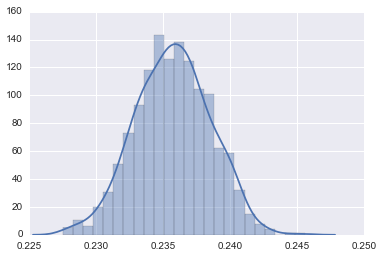

In [79]:
sns.distplot(test_b)

In [80]:
bird_total.ix['FINAL_SCORE'].per_H_wh

0.19323112525310962

Significant result for birds too

In [81]:
test_c = [coral_unique[coral_unique.Fullname.isin(np.random.choice(coral_unique.Fullname, 724, replace=False))][c_columns].apply(get_hlu).T.ix['FINAL_SCORE'].per_H\
          for i in range(1000)]

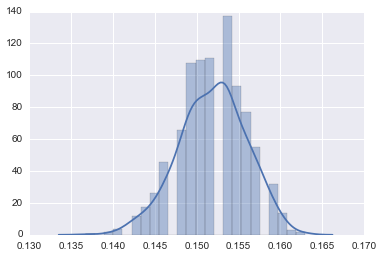

In [82]:
sns.distplot(test_c)

In [83]:
coral_total.ix['FINAL_SCORE'].per_H_wh

0.15331491712707182

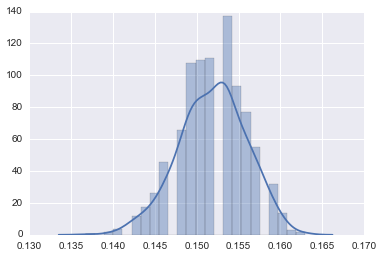

In [84]:
sns.distplot(test_c)

### WH vs all species

In [342]:
# a function to plot all columns using stacked horizontal barchart
def plot_comparison(wh_species, all_species, columns):
    my_colors = ['#b2182b', '#ffffff', '#e0e0e0']
    col = len(columns)
    fig, axes = plt.subplots(col, figsize=(15, 2*col)) # len and heihgt
    
    fig.subplots_adjust(hspace = 0.5)
    
    # get agg count of HLUso
    a = get_agg_result(wh_species, columns)
    b = get_agg_result(all_species, columns)
        
    for i, column in enumerate(columns):
        data = pd.concat([a[['H', 'L', 'U']].loc[column], 
                      b[['H', 'L', 'U']].loc[column]], 1).T
        data.index = ['Species in World Heritage sites', 'All species']
        data.plot.barh(ax=axes[i], stacked=True, color=my_colors)
        axes[i].set_xlim([0, all_species.index.size*1.1])
        axes[i].set_title(column)
    
#         # aesthetics
#         axes[i].grid(False)
#         axes[i].set_axis_bgcolor('#ffffff')
    return fig

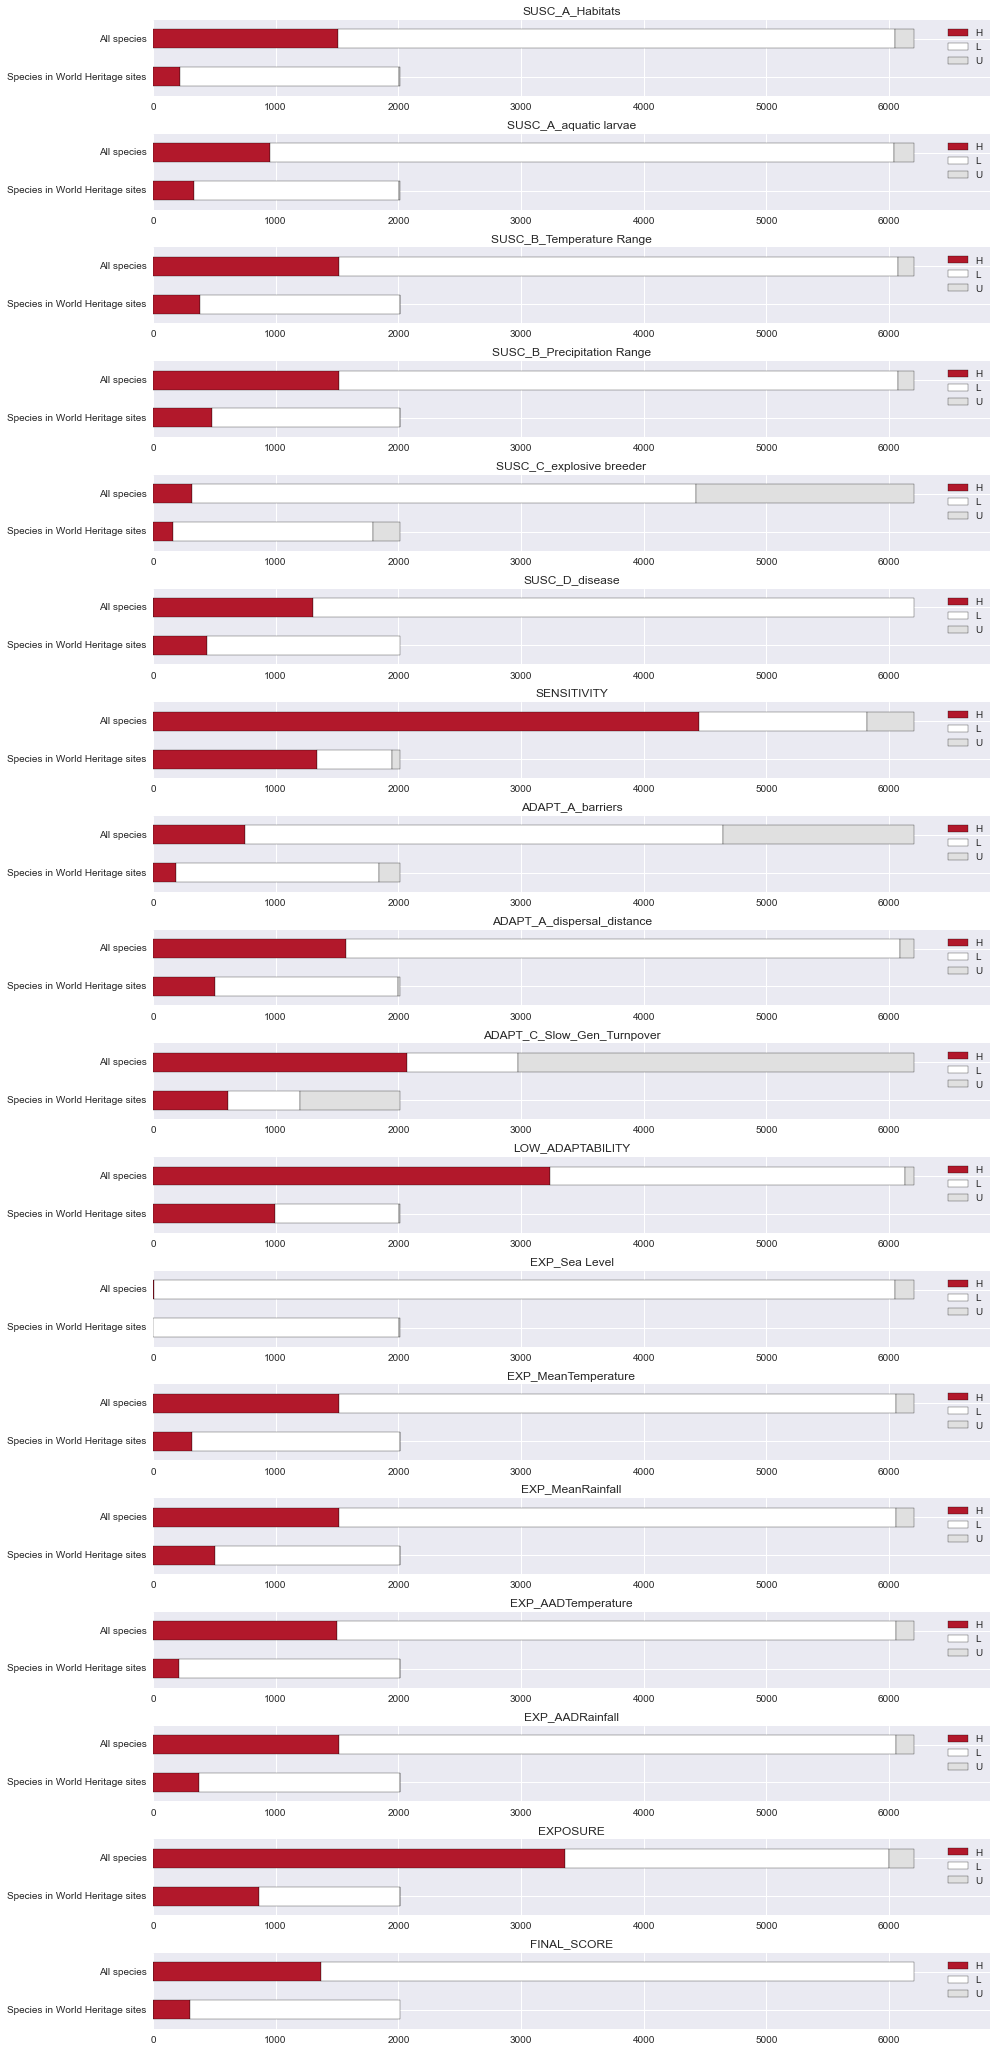

In [343]:
# amp
plot_comparison(amp_selected, amp, a_columns);

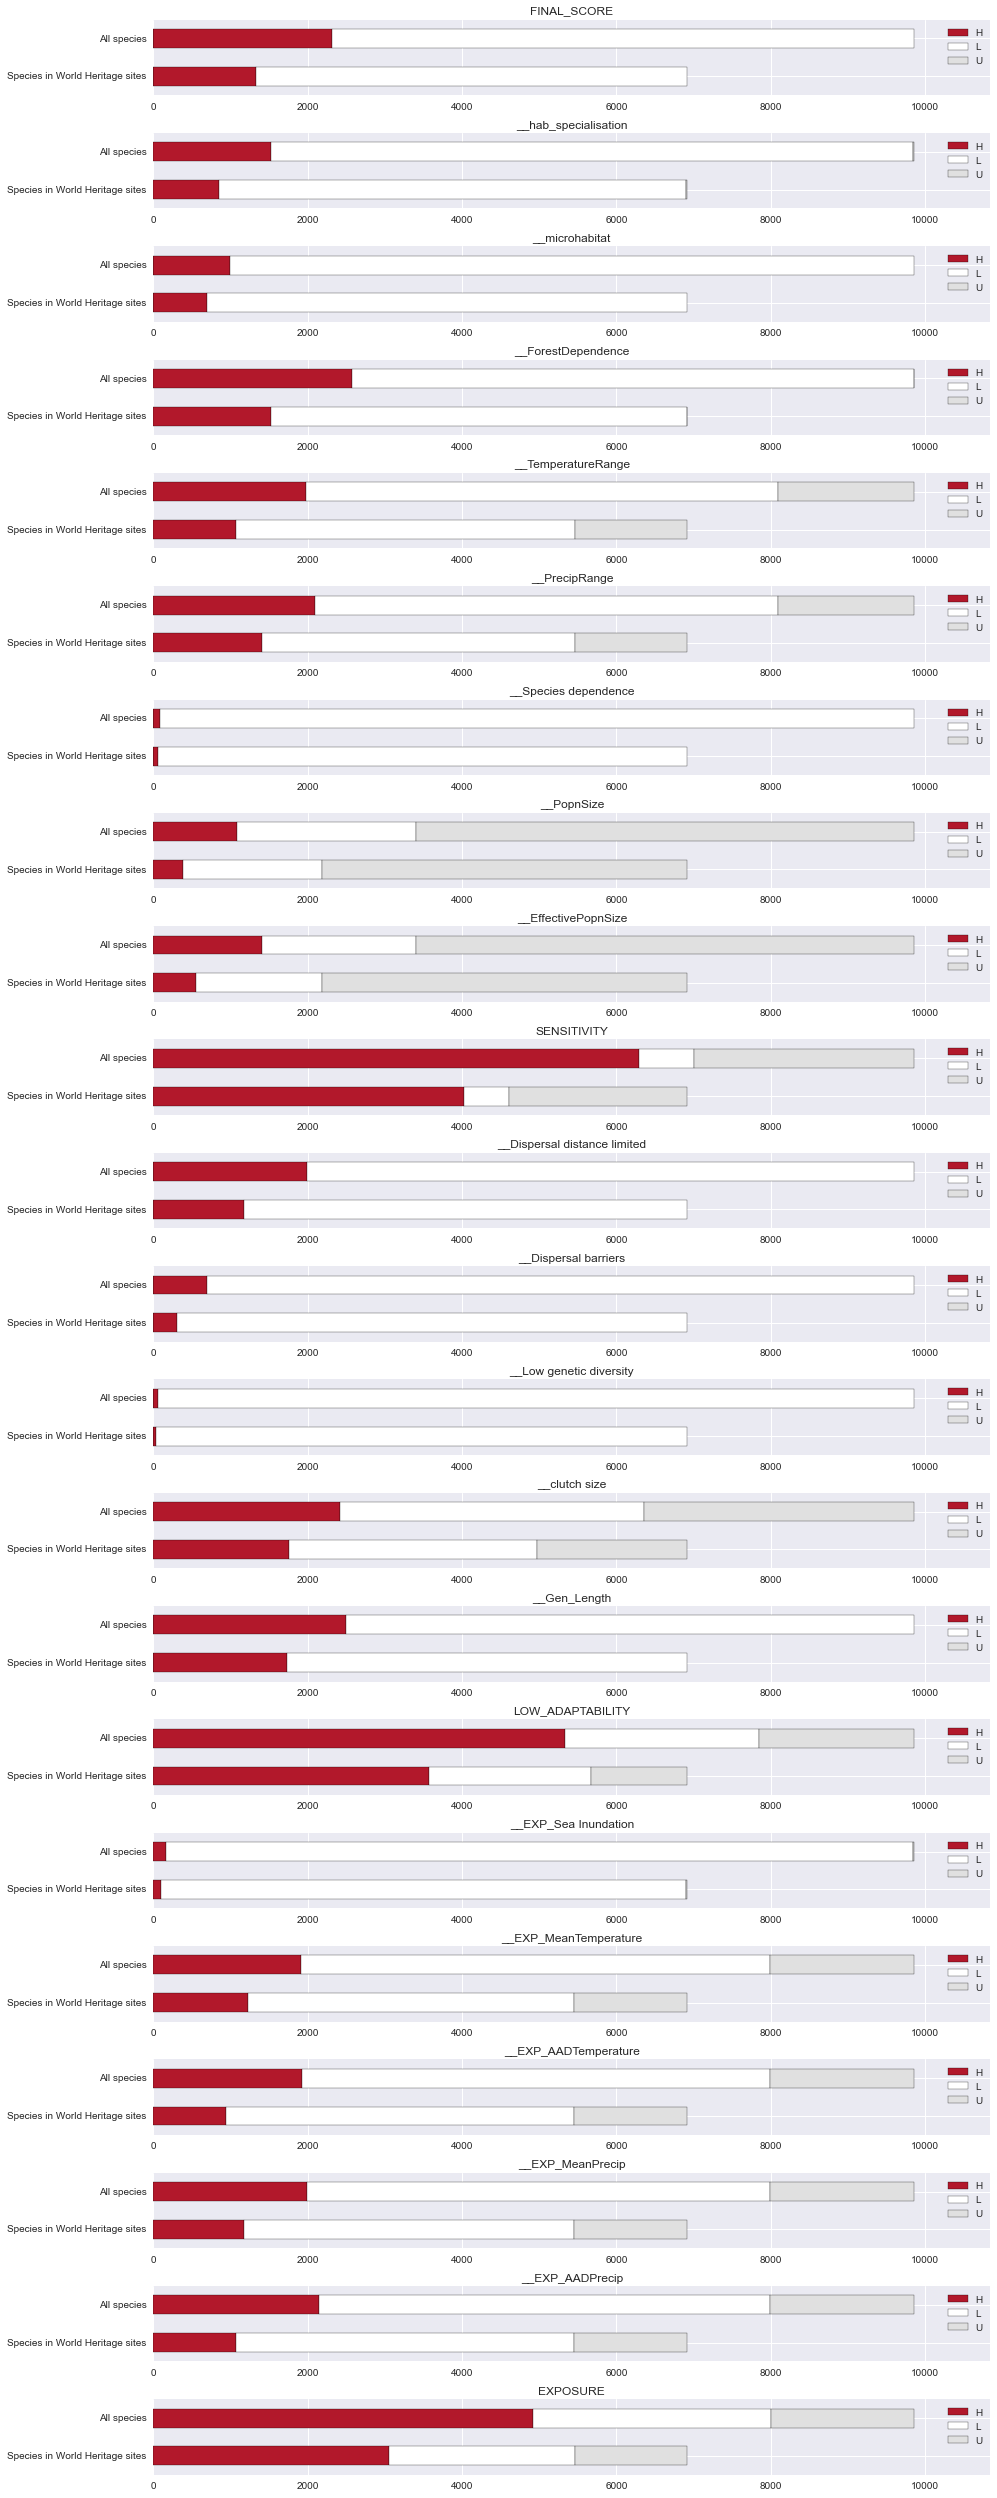

In [344]:
# bird
plot_comparison(bird_selected, bird, b_columns);

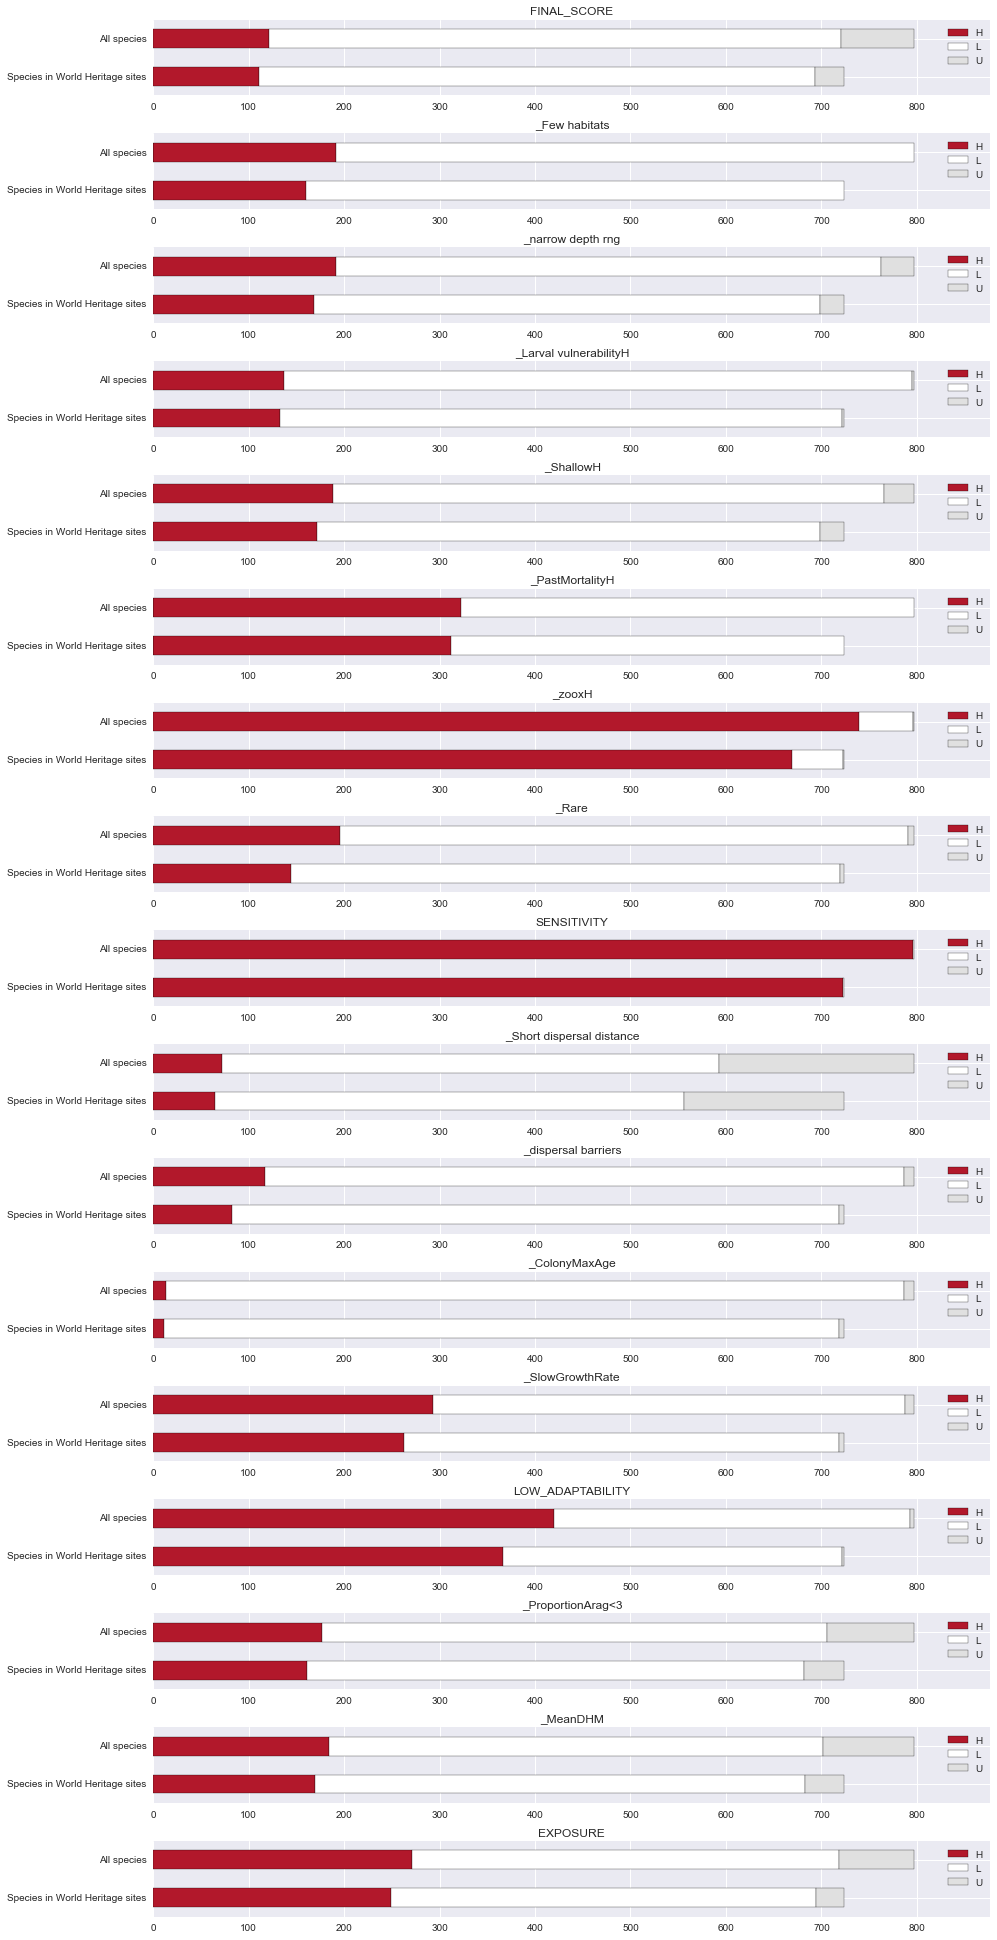

In [345]:
# coral
plot_comparison(coral_selected, coral_unique, c_columns);

### WH vs bioWH
It is quite interesting to further examine subsets of WH sites, for example, by regions and by criteria, with a view to answering questions such as a) do biodiversity WH sites have more climate vulnerable species b) do WH sites in asian regions host more CV species?

In [85]:
type(amp_selected.crit)

pandas.core.series.Series

In [86]:
# try testing regular expression and `pd.series.str.match`
pattern = r'.*x.*' # crit having character `x` indicates a biodiversity WH site
test_matching = pd.concat([amp_selected.crit, amp_selected.crit.str.match(pattern)], 1)

# get a filter for biodi
amp_wh_bio_filter = amp_selected.crit.str.match(pattern)
bird_wh_bio_filter = bird_selected.crit.str.match(pattern)
coral_wh_bio_filter = coral_selected.crit.str.match(pattern)

# reduction in the number of WH sites
print('all WH', 'only bWH')
print(amp_selected.wdpaid.unique().size, amp_selected[amp_wh_bio_filter].wdpaid.unique().size)
print(bird_selected.wdpaid.unique().size, bird_selected[bird_wh_bio_filter].wdpaid.unique().size)
print(coral_selected.wdpaid.unique().size, coral_selected[coral_wh_bio_filter].wdpaid.unique().size)

all WH only bWH
150 116
184 147
26 23


In [87]:
# do comparison between subset of 
amp_wh_bio = pd.merge(amp_selected[amp_wh_bio_filter][a_columns].apply(get_hlu).T, \
         amp_selected[a_columns].apply(get_hlu).T, \
         left_index = True, right_index=True, suffixes=('_bio', '_wh'))

bird_wh_bio = pd.merge(bird_selected[bird_wh_bio_filter][b_columns].apply(get_hlu).T, \
         bird_selected[b_columns].apply(get_hlu).T, \
         left_index = True, right_index=True, suffixes=('_bio', '_wh'))

coral_wh_bio = pd.merge(coral_selected[coral_wh_bio_filter][c_columns].apply(get_hlu).T, \
         coral_selected[c_columns].apply(get_hlu).T, \
         left_index = True, right_index=True, suffixes=('_bio', '_wh'))

In [88]:
amp_wh_bio

,H_bio,L_bio,U_bio,per_H_bio,H_wh,L_wh,U_wh,per_H_wh
SUSC_A_Habitats,215.0,1664.0,9.0,0.113877,220.0,1783.0,10.0,0.109290
SUSC_A_aquatic larvae,293.0,1586.0,9.0,0.155191,330.0,1673.0,10.0,0.163934
SUSC_B_Temperature Range,385.0,1502.0,1.0,0.203919,386.0,1626.0,1.0,0.191754
SUSC_B_Precipitation Range,423.0,1464.0,1.0,0.224047,479.0,1533.0,1.0,0.237953
SUSC_C_explosive breeder,151.0,1526.0,211.0,0.079979,162.0,1629.0,222.0,0.080477
SUSC_D_disease,412.0,1476.0,0.0,0.218220,436.0,1577.0,0.0,0.216592
SENSITIVITY,1260.0,563.0,65.0,0.667373,1340.0,606.0,67.0,0.665673
ADAPT_A_barriers,174.0,1548.0,166.0,0.092161,183.0,1661.0,169.0,0.090909
ADAPT_A_dispersal_distance,484.0,1385.0,19.0,0.256356,501.0,1493.0,19.0,0.248882
ADAPT_C_Slow_Gen_Turnpover,584.0,532.0,772.0,0.309322,609.0,586.0,818.0,0.302534


In [89]:
bird_wh_bio

,H_bio,L_bio,U_bio,per_H_bio,H_wh,L_wh,U_wh,per_H_wh
FINAL_SCORE,1208.0,4834.0,0.0,0.199934,1336.0,5578.0,0.0,0.193231
__hab_specialisation,777.0,5259.0,6.0,0.128600,849.0,6059.0,6.0,0.122794
__microhabitat,644.0,5398.0,0.0,0.106587,703.0,6211.0,0.0,0.101678
__ForestDependence,1419.0,4622.0,1.0,0.234856,1527.0,5386.0,1.0,0.220856
__TemperatureRange,1062.0,3779.0,1201.0,0.175770,1068.0,4401.0,1445.0,0.154469
__PrecipRange,1046.0,3795.0,1201.0,0.173121,1414.0,4055.0,1445.0,0.204513
__Species dependence,66.0,5976.0,0.0,0.010924,66.0,6848.0,0.0,0.009546
__PopnSize,348.0,1446.0,4248.0,0.057597,393.0,1794.0,4727.0,0.056841
__EffectivePopnSize,493.0,1301.0,4248.0,0.081595,558.0,1629.0,4727.0,0.080706
SENSITIVITY,3494.0,521.0,2027.0,0.578285,4022.0,585.0,2307.0,0.581718


In [90]:
coral_wh_bio

,H_bio,L_bio,U_bio,per_H_bio,H_wh,L_wh,U_wh,per_H_wh
FINAL_SCORE,106.0,578.0,30.0,0.148459,111.0,582.0,31.0,0.153315
_Few habitats,155.0,559.0,0.0,0.217087,160.0,564.0,0.0,0.220994
_narrow depth rng,164.0,526.0,24.0,0.229692,169.0,529.0,26.0,0.233425
_Larval vulnerabilityH,130.0,582.0,2.0,0.182073,133.0,589.0,2.0,0.183702
_ShallowH,168.0,523.0,23.0,0.235294,172.0,527.0,25.0,0.237569
_PastMortalityH,310.0,404.0,0.0,0.434174,312.0,412.0,0.0,0.430939
_zooxH,659.0,54.0,1.0,0.922969,669.0,54.0,1.0,0.924033
_Rare,137.0,573.0,4.0,0.191877,144.0,575.0,5.0,0.198895
SENSITIVITY,713.0,1.0,0.0,0.998599,723.0,1.0,0.0,0.998619
_Short dispersal distance,61.0,487.0,166.0,0.085434,65.0,491.0,168.0,0.089779


It appears that subdivision by separating biodiversity sites from all natural sites does not indicate a different picture. The percentage difference is minute.

### WH by regions
Check differences according to regions

In [91]:
# load regions
region = pd.read_csv('region.csv')

In [92]:
region.unesco_reg.unique()

array(['Africa', 'Arab States', 'Asia and the Pacific',
       'Europe and North America', 'Latin America and the Caribbean'], dtype=object)

In [126]:
# convenient variables
regions_list = ['_africa', '_asia', '_euna', '_lac', '_arab']
regions_name_list = ['Africa', 'Asia and the Pacific', 'Europe and North America', 'Latin America and the Caribbean', 'Arab States']

In [127]:
# africa_ids = region[region.unesco_reg == 'Africa'].wdpaid
# asia_ids = region[region.unesco_reg == 'Asia and the Pacific'].wdpaid
# euna_ids = region[region.unesco_reg == 'Europe and North America'].wdpaid
# lac_ids = region[region.unesco_reg == 'Latin America and the Caribbean'].wdpaid
# arab_ids = region[region.unesco_reg == 'Arab States'].wdpaid

# more concise version using list comprehension
africa_ids, asia_ids, euna_ids, lac_ids, arab_ids = [region[region.unesco_reg == region_name].wdpaid for region_name in \
                                                     regions_name_list]


In [128]:
print([len(x) for x in [africa_ids, asia_ids, euna_ids, lac_ids, arab_ids]])

[41, 70, 71, 41, 6]


In [95]:
# get a function that returns the result of aggregates
def get_agg_result_by_wdpaidlist(taxon_result, taxon_columns, filtered_wdpaids):
    # get a unique list of species for sites, based on the filtered wdpaids
    unique_taxon_result = taxon_result[taxon_result.wdpaid.isin(filtered_wdpaids)].groupby('id_no_int').first().reset_index()
    # apply the stangdard aggregation methods
    return unique_taxon_result[taxon_columns].apply(get_hlu).T

In [96]:
# amp in wh sites by region
amp_africa, amp_asia, amp_euna, amp_lac, amp_arab = \
[get_agg_result_by_wdpaidlist(result_amp_f, a_columns, a_region) \
 for a_region in [africa_ids, asia_ids, euna_ids, lac_ids, arab_ids]]
amp_regions = [amp_africa, amp_asia, amp_euna, amp_lac, amp_arab]

# bird in wh sites by region
bird_africa, bird_asia, bird_euna, bird_lac, bird_arab = \
[get_agg_result_by_wdpaidlist(result_bird_f, b_columns, a_region) \
 for a_region in [africa_ids, asia_ids, euna_ids, lac_ids, arab_ids]]
bird_regions = [bird_africa, bird_asia, bird_euna, bird_lac, bird_arab]

# coral in wh sites by region
coral_africa, coral_asia, coral_euna, coral_lac, coral_arab = \
[get_agg_result_by_wdpaidlist(result_coral_f, c_columns, a_region) \
 for a_region in [africa_ids, asia_ids, euna_ids, lac_ids, arab_ids]]
coral_regions = [coral_africa, coral_asia, coral_euna, coral_lac, coral_arab]


In [141]:
# join all the regional tables together
from functools import reduce

# use reduce function to merge any given number of dfs; here i used a tuple in order to get suffix information
# the first element is the df, the second a dummy value used in the reduce process
amp_region_final = reduce(lambda left, right: (pd.merge(left[0], right[0], left_index=True, right_index=True, \
                                              suffixes = ('', right[1])), 0), \
                  zip(amp_regions, regions_list),
                 (amp_selected[a_columns].apply(get_hlu).T, 0))[0]

bird_region_final = reduce(lambda left, right: (pd.merge(left[0], right[0], left_index=True, right_index=True, \
                                              suffixes = ('', right[1])), 0), \
                  zip(bird_regions, regions_list),
                 (bird_selected[b_columns].apply(get_hlu).T, 0))[0]

coral_region_final = reduce(lambda left, right: (pd.merge(left[0], right[0], left_index=True, right_index=True, \
                                              suffixes = ('', right[1])), 0), \
                  zip(coral_regions, regions_list),
                 (coral_selected[c_columns].apply(get_hlu).T, 0))[0]

In [142]:
amp_region_final[['per_H' + each for each in ['', '_africa', '_asia', '_euna', '_lac', '_arab']]]

,per_H,per_H_africa,per_H_asia,per_H_euna,per_H_lac,per_H_arab
SUSC_A_Habitats,0.109290,0.089524,0.067434,0.068966,0.165975,0.000000
SUSC_A_aquatic larvae,0.163934,0.278095,0.139803,0.183908,0.095436,0.666667
SUSC_B_Temperature Range,0.191754,0.241905,0.069079,0.000000,0.300138,0.000000
SUSC_B_Precipitation Range,0.237953,0.184762,0.231908,0.839080,0.147994,1.000000
SUSC_C_explosive breeder,0.080477,0.160000,0.059211,0.045977,0.052559,0.333333
SUSC_D_disease,0.216592,0.019048,0.185855,0.126437,0.410788,0.000000
SENSITIVITY,0.665673,0.636190,0.483553,0.885057,0.791148,1.000000
ADAPT_A_barriers,0.090909,0.093333,0.144737,0.045977,0.053942,0.166667
ADAPT_A_dispersal_distance,0.248882,0.264762,0.199013,0.143678,0.302905,0.000000
ADAPT_C_Slow_Gen_Turnpover,0.302534,0.346667,0.250000,0.327586,0.302905,0.000000


In [140]:
amp_region_final.loc['FINAL_SCORE']

H                301.000000
L               1712.000000
U                  0.000000
per_H              0.149528
H_africa          48.000000
L_africa         477.000000
U_africa           0.000000
per_H_africa       0.091429
H_asia            62.000000
L_asia           546.000000
U_asia             0.000000
per_H_asia         0.101974
H_euna            17.000000
L_euna           157.000000
U_euna             0.000000
per_H_euna         0.097701
H_lac            178.000000
L_lac            545.000000
U_lac              0.000000
per_H_lac          0.246196
H_arab             1.000000
L_arab             5.000000
U_arab             0.000000
per_H_arab         0.166667
Name: FINAL_SCORE, dtype: float64

In [143]:
bird_region_final.loc['FINAL_SCORE']

H               1336.000000
L               5578.000000
U                  0.000000
per_H              0.193231
H_africa         209.000000
L_africa        1410.000000
U_africa           0.000000
per_H_africa       0.129092
H_asia           457.000000
L_asia          2117.000000
U_asia             0.000000
per_H_asia         0.177545
H_euna           212.000000
L_euna           868.000000
U_euna             0.000000
per_H_euna         0.196296
H_lac            703.000000
L_lac           2120.000000
U_lac              0.000000
per_H_lac          0.249026
H_arab            71.000000
L_arab           226.000000
U_arab             0.000000
per_H_arab         0.239057
Name: FINAL_SCORE, dtype: float64

In [144]:
coral_region_final.loc['FINAL_SCORE']

H               111.000000
L               582.000000
U                31.000000
per_H             0.153315
H_africa         20.000000
L_africa        281.000000
U_africa          4.000000
per_H_africa      0.065574
H_asia           60.000000
L_asia          543.000000
U_asia            5.000000
per_H_asia        0.098684
H_euna           43.000000
L_euna          395.000000
U_euna            4.000000
per_H_euna        0.097285
H_lac            30.000000
L_lac            54.000000
U_lac             1.000000
per_H_lac         0.352941
H_arab           12.000000
L_arab          197.000000
U_arab           22.000000
per_H_arab        0.051948
Name: FINAL_SCORE, dtype: float64

It is very difficult to find patterns in a table full of numbers like the above. Graphs may present a much better view in terms of the underlying differences.

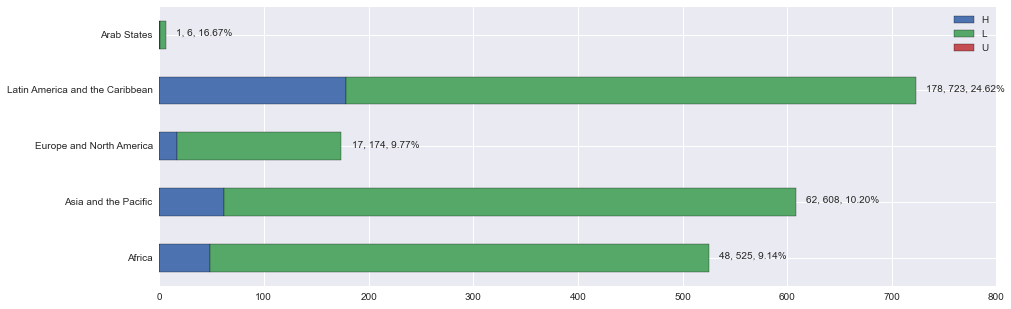

In [130]:
# amp
# a = pd.concat([each[['H', 'L', 'U']][-1:] for each in amp_regions])
## a better way to slice columns and rows, loc is a label based indxing
## .loc returns a series, concatenate on axis 1, transpose and then replace index, so that they'll show up as labels

# get df for all regions, with HLU
a = pd.concat([each[['H', 'L', 'U']].loc['FINAL_SCORE'] for each in amp_regions], 1).T

a.index = regions_name_list
b = a.plot.barh(stacked=True, figsize=(15,5))

# for each bar, annotate num of 'H' and percentage of 'H'
for region_name, region_data, y_axis in zip(regions_name_list, amp_regions, range(5)):
    b.annotate('{0:.0f}'.format(a.loc[region_name].H) + ', ' + '{0:.0f}'.format(a.loc[region_name].sum()) + ', ' + '{0:.2%}'.format(region_data.loc['FINAL_SCORE'].per_H),
              (a.loc[region_name].sum() + 10, y_axis)) # add a buf-space for x

In [155]:
## find amphibians species in arab states WH sites
pd.set_option('display.max_columns', 60)
example = result_amp_f[result_amp_f.wdpaid.isin(arab_ids)]
example[example.FINAL_SCORE=='H']

,SVP_ID,SIS_GAA_ID,GAA Family,Genus,Species,Fullname,Threatened,SUSC_A_Habitats,SUSC_A_aquatic larvae,SUSC_B_Temperature Range,SUSC_B_Precipitation Range,SUSC_C_explosive breeder,SUSC_D_disease,SENSITIVITY,ADAPT_A_barriers,ADAPT_A_dispersal_distance,ADAPT_C_Slow_Gen_Turnpover,LOW_ADAPTABILITY,EXP_Sea Level,EXP_MeanTemperature,EXP_MeanRainfall,EXP_AADTemperature,EXP_AADRainfall,EXPOSURE,FINAL_SCORE,Final_Pessimistic,Score_HorS,SensXLAdaptability,SensXExposure,LAdaptXExposure,Threatened_and_Vulnerable,Unnamed: 0,wdpaid,id_no,areakm2_x,areakm2_y,per,en_name,fr_name,status_yr,rep_area,gis_area,country,crit,areakm2,binomial,kingdom_name,phylum_name,class_name,order_name,family_name,genus_name,species_name,category,biome_marine,biome_freshwater,biome_terrestrial,id_no_int
1132,3152,6187,ALYTIDAE,Discoglossus,pictus,Discoglossus pictus,NaN,L,L,L,H,L,L,H,H,L,L,H,L,L,H,L,H,H,H,H,H,H,NaN,NaN,NaN,126160,4322,55270.0,124.424076,124.424076,1.0,Ichkeul National Park,Parc national de l'Ichkeul,1980,126.0,124.424076,TUN,(x),124.424076,Discoglossus pictus,ANIMALIA,CHORDATA,AMPHIBIA,ANURA,ALYTIDAE,Discoglossus,pictus,LC,f,t,t,55270.0


Latin America and the Caribbean region contains the highest number of amphibians that are climate vulnerable (178, out of a total of 723, 24.62%), compared to about 10% for WH sites in other regions. Notably on the other end of the spectrum, WH sites in the Arab States region host very few ampbibans and only one of them is climate vulnerable (Discoglossus pictus in Ichkeul National Park, based on the IUCN Red List data).

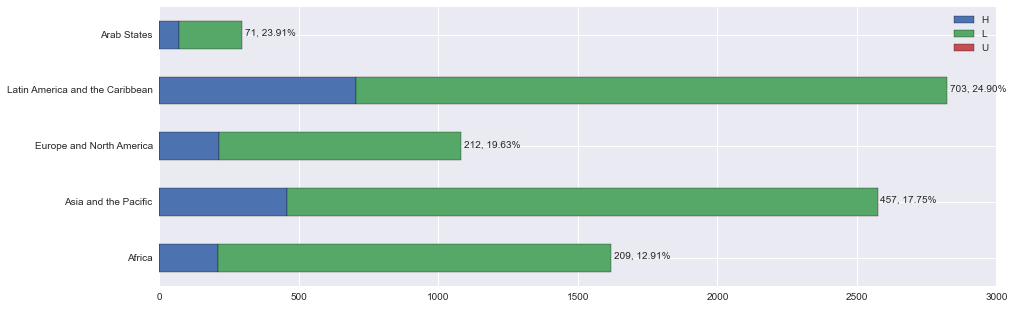

In [156]:
# bird
a = pd.concat([each[['H', 'L', 'U']].loc['FINAL_SCORE'] for each in bird_regions], 1).T
a.index = regions_name_list
b = a.plot.barh(stacked=True, figsize=(15,5))
# # testing annotation, note y axis is from bottom up. unit based on data

# for each bar, annotate num of 'H' and percentage of 'H'
for region_name, region_data, y_axis in zip(regions_name_list, bird_regions, range(5)):
    b.annotate('{0:.0f}'.format(a.loc[region_name].H) + ', ' + '{0:.2%}'.format(region_data.loc['FINAL_SCORE'].per_H),
              (a.loc[region_name].sum() + 10, y_axis)) # add a buf-space for x


Similarly from the point of view of climate vulnerable birds in global WH network, Latin America and the Caribbean region has the largest number of birds, and a quarter of them are climate vulnerable, compared to other regions.

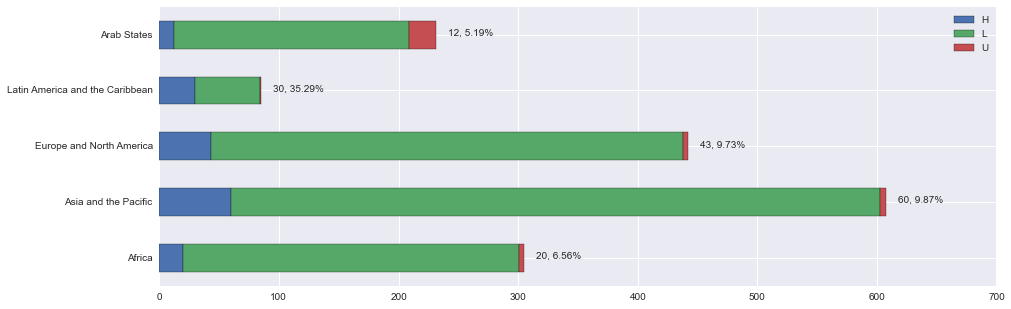

In [236]:
# coral
a = pd.concat([each[['H', 'L', 'U']].loc['FINAL_SCORE'] for each in coral_regions], 1).T
a.index = regions_name_list
b = a.plot.barh(stacked=True, figsize=(15,5))

# for each bar, annotate num of 'H' and percentage of 'H'
for region_name, region_data, y_axis in zip(regions_name_list, coral_regions, range(5)):
    b.annotate('{0:.0f}'.format(a.loc[region_name].H) + ', ' + '{0:.2%}'.format(region_data.loc['FINAL_SCORE'].per_H),
              (a.loc[region_name].sum() + 10, y_axis)) # add a buf-space for x

The above regional comparisons across amphibians, birds and corals indicate a large variation in the number and proportion of cimate vulnerable species in the World Heritage network.

##### More visualisations on the proportions beyond just the final vulnerability score...
Need to apply the same methodology across all attributes, i.e. sensitivity, low-adaptability and each of the traits...

In [250]:
# enumerate to get index number, which is needed in the plot
for i, column in enumerate(a_columns):
    print(i, column)

0 SUSC_A_Habitats
1 SUSC_A_aquatic larvae
2 SUSC_B_Temperature Range
3 SUSC_B_Precipitation Range
4 SUSC_C_explosive breeder
5 SUSC_D_disease
6 SENSITIVITY
7 ADAPT_A_barriers
8 ADAPT_A_dispersal_distance
9 ADAPT_C_Slow_Gen_Turnpover
10 LOW_ADAPTABILITY
11 EXP_Sea Level
12 EXP_MeanTemperature
13 EXP_MeanRainfall
14 EXP_AADTemperature
15 EXP_AADRainfall
16 EXPOSURE
17 FINAL_SCORE


In [362]:
# a function to plot all columns using stacked horizontal barchart
def plot_all_attributes(taxon_regions, region_namelist, columns):
    my_colors = ['#b2182b', '#ffffff', '#e0e0e0']
    
    # create a figure with correct number of axes 
    col = len(columns)
    fig, axes = plt.subplots(nrows = col, figsize=(15, 5*col)) # width and heihgt
    fig.subplots_adjust(hspace = 0.3)
    
    # for each exes, plot a column result for all regions, for comparisons
    for i, column in enumerate(columns):
        # a df of all regions HLUs
        a = pd.concat([each[['H', 'L', 'U']].loc[column] for each in taxon_regions], 1).T
        a.index = region_namelist
        
        # so it also works for col=1. If col=1, axes is not an array and thus does not support indexing
        if col>1:
            b = a.plot.barh(ax=axes[i], stacked=True, color=my_colors)
            axes[i].set_title(column)
        else:
            b = a.plot.barh(ax=axes, stacked=True, color=my_colors)
            axes.set_title(column)            
    
        # add num of H, total num and percentage as annotation
        for region_name, region_data, y_axis in zip(region_namelist, taxon_regions, range(len(region_namelist))):
            b.annotate('{0:.0f}'.format(a.loc[region_name].H) + ', ' + '{0:.0f}'.format(a.loc[region_name].sum()) + \
                       ', ' + '{0:.2%}'.format(region_data.loc[column].per_H),
                      (a.loc[region_name].sum() + 10, y_axis))
    
    return fig

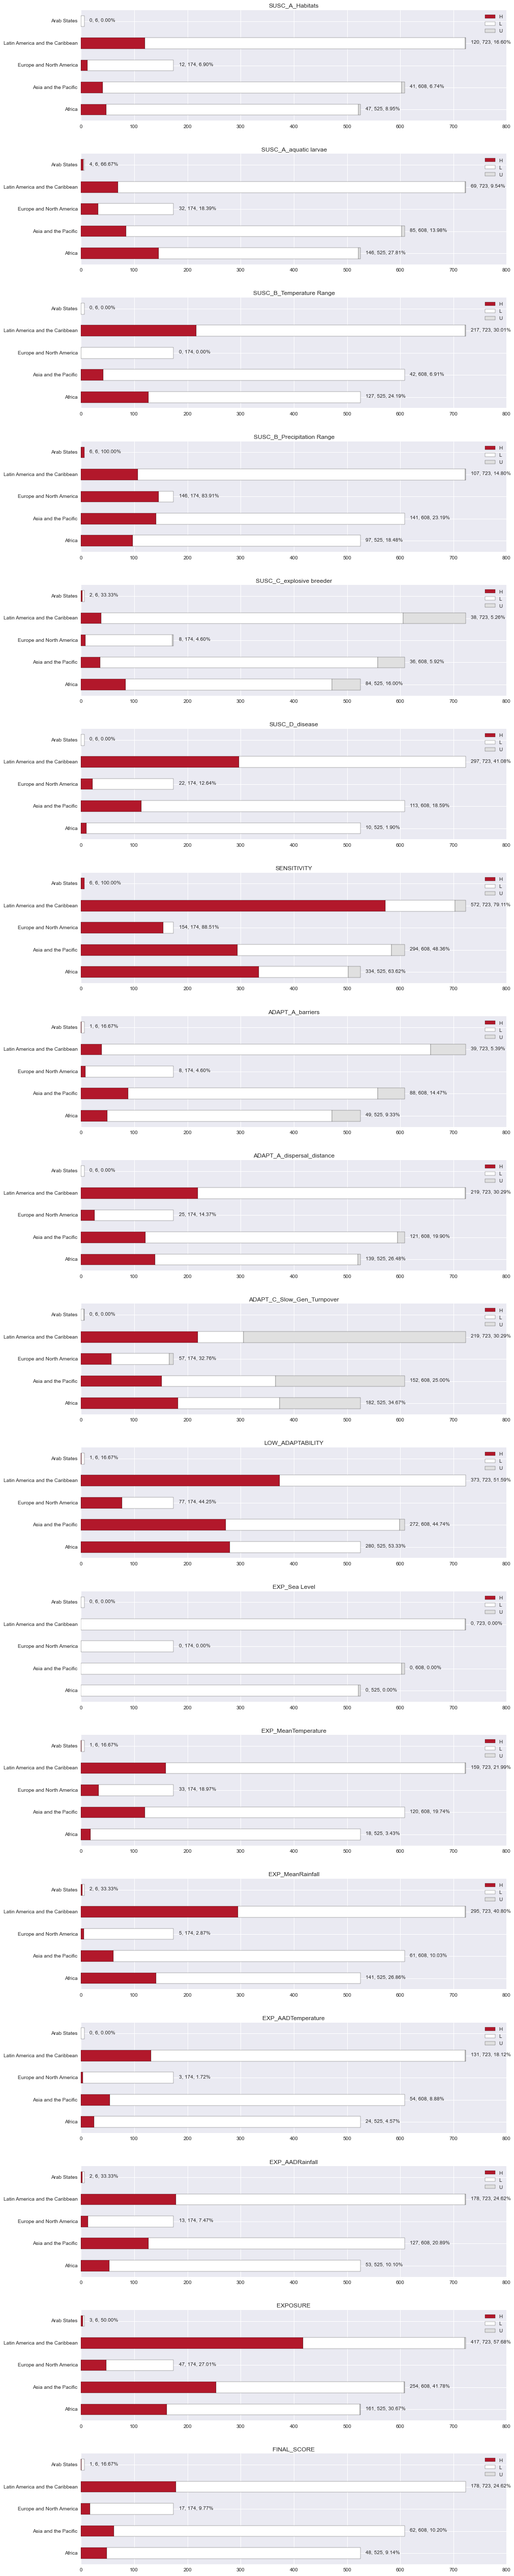

In [364]:
# need to add `;` to suppress the automatic behaviour that plots the same graph twice
plot_all_attributes(amp_regions, regions_name_list, a_columns);

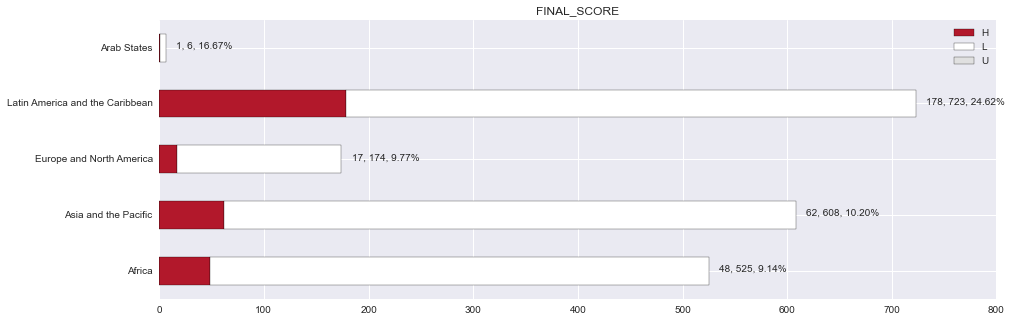

In [363]:
# test for single column and it also works now
plot_all_attributes(amp_regions, regions_name_list, ['FINAL_SCORE']);

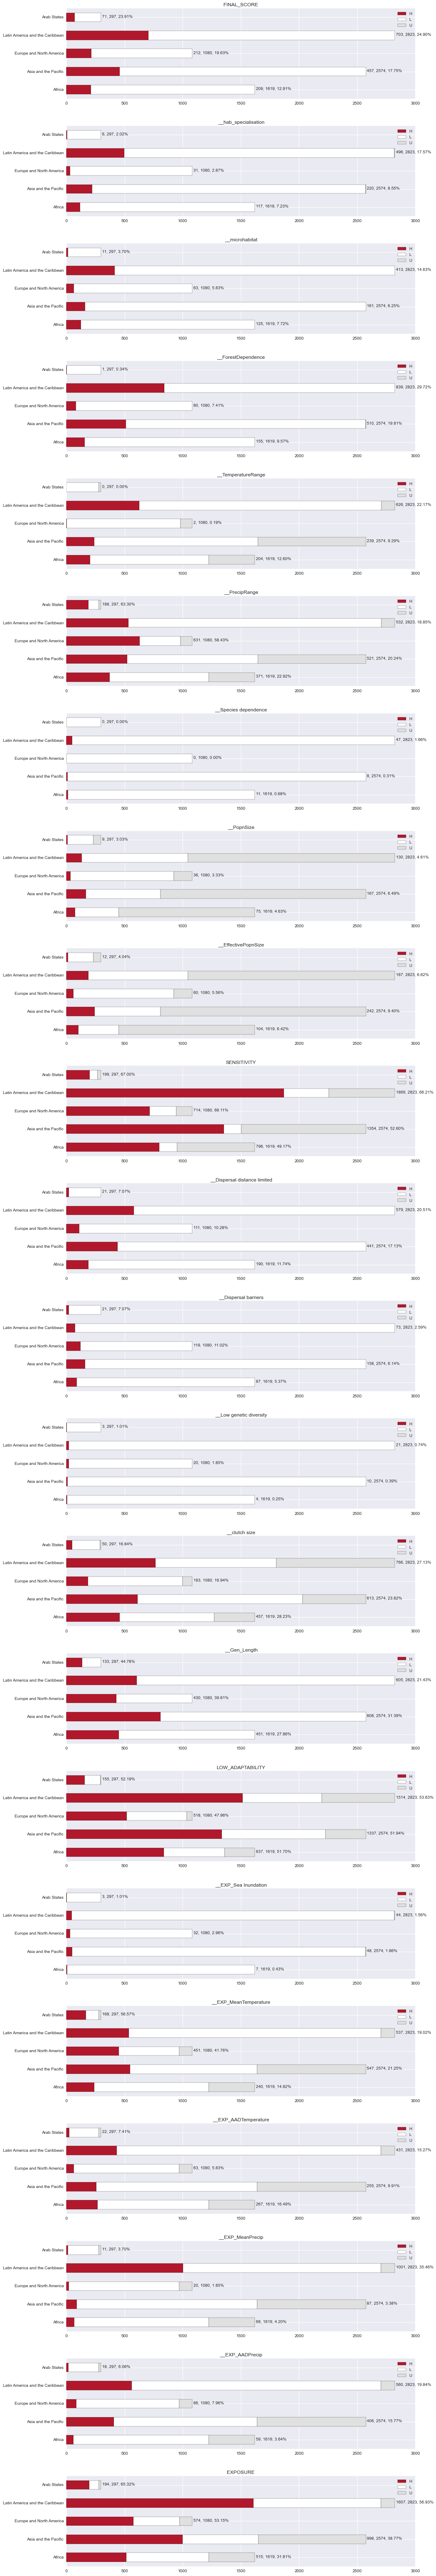

In [365]:
plot_all_attributes(bird_regions, regions_name_list, b_columns);

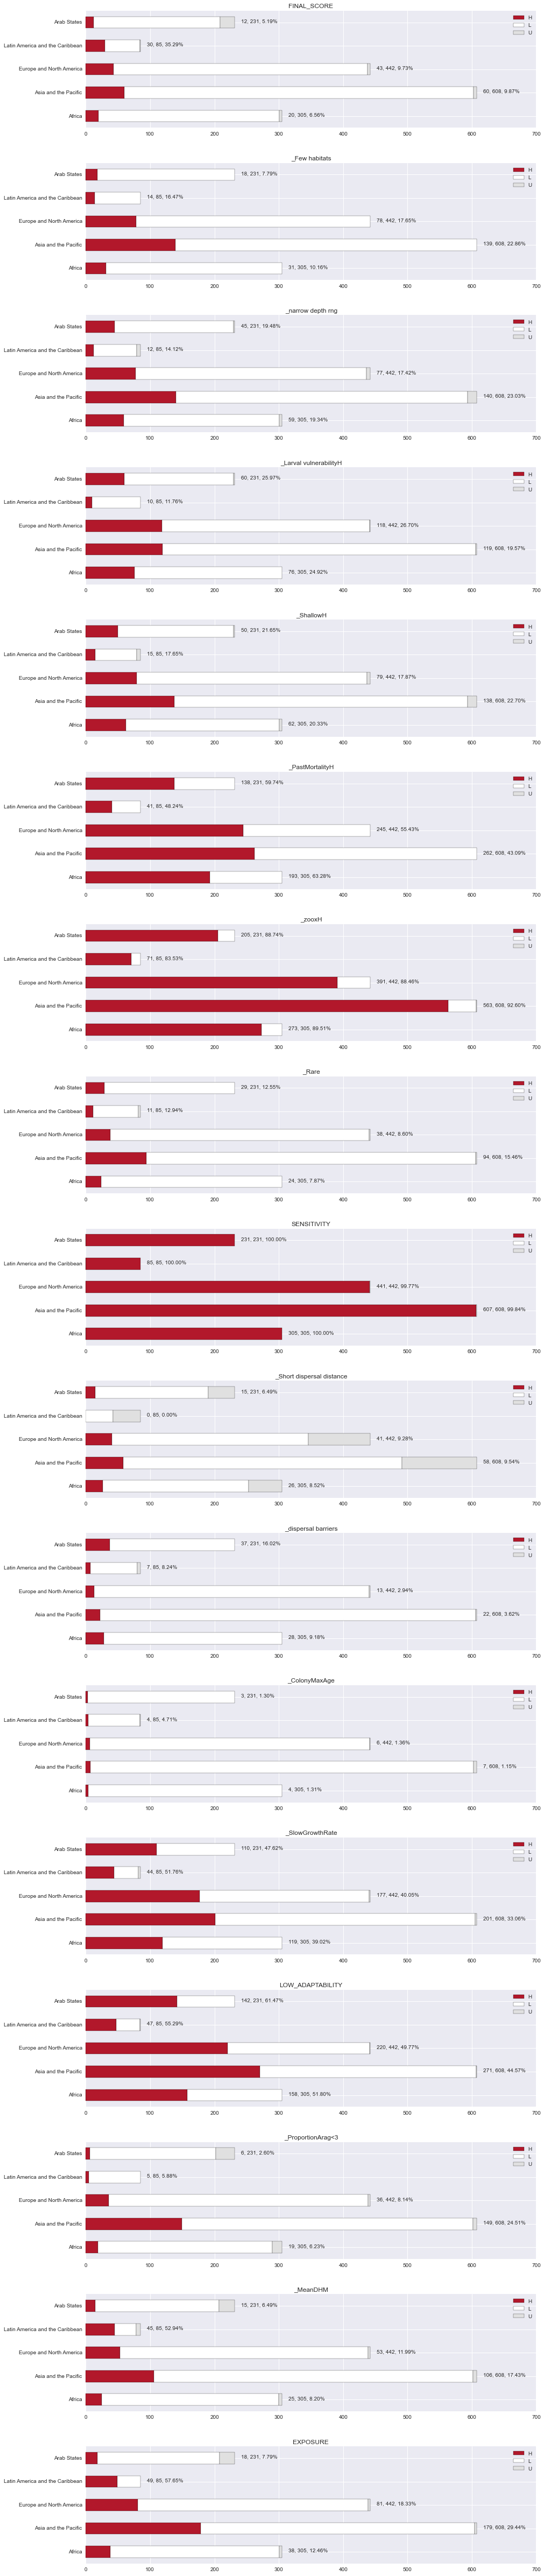

In [366]:
plot_all_attributes(coral_regions, regions_name_list, c_columns);

Sensitivity seems rather weird - all species across all regions have sensitivity high?

In [265]:
(coral_unique.SENSITIVITY == 'H').sum(), coral_unique.index.size

(796, 797)